### FINM33150 - Quant Trading Strategies
## Homework 6
## University of Chicago


### Author: Laurent Lanteigne
### ID: 12279717
### Date: May 13th, 2021

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import random
import seaborn as sns
import quandl
import datetime as dt
import functools
import os
from tqdm import tqdm
import copy
import time
from datetime import timedelta
from datetime import datetime
from sklearn import linear_model as lm
from scipy.optimize import minimize_scalar
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
quandl_key = os.environ.get('QUANDL_API_KEY') # Works now, might need to reset env or computer to have it work 

In [2]:
plt.style.use('seaborn-bright')

%matplotlib inline
pd.set_option("precision", 6)

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# 1. Data

In [5]:
cds_df = pd.read_csv("Liq5YCDS.delim", sep='\t')
cds_df.drop(columns = ['Unnamed: 0','recovery'],inplace = True)
cds_df = cds_df.pivot(index = 'date', columns = 'ticker',values= 'spread5y')
cds_df.index = pd.to_datetime(cds_df.index)

In [6]:
cds_df = cds_df.resample("W-Wed").first()[:-1]
cds_df.head()

ticker,BA,C,DD,F,GE,JPM,LOW,LUV,MAR,T,WFC,XOM
date,,,,,,,,,,,,
2018-01-03,0.001793,0.004113,0.002476,0.008805,0.004037,0.003901,0.001546,0.003107,0.003588,0.005179,0.004261,0.003387
2018-01-10,0.001659,0.003968,0.002374,0.008306,0.004025,0.003752,0.001397,0.002880,0.002314,0.005180,0.004217,0.003407
2018-01-17,0.001630,0.004043,0.002409,0.008629,0.004078,0.003895,0.001347,0.003107,0.002519,0.005178,0.004144,0.003308
2018-01-24,0.001783,0.004098,0.002695,0.010011,0.005108,0.003823,0.002176,0.003362,0.002852,0.005178,0.004215,0.003304
2018-01-31,0.001699,0.004031,0.002689,0.010360,0.005916,0.003735,0.002403,0.003643,0.002775,0.005177,0.004111,0.003180


In [7]:
cds_df = cds_df.apply(np.log).diff().iloc[1:]
cds_df.head()

ticker,BA,C,DD,F,GE,JPM,LOW,LUV,MAR,T,WFC,XOM
date,,,,,,,,,,,,
2018-01-10,-0.078066,-0.035858,-0.042085,-0.058296,-0.003019,-0.039085,-0.101367,-0.075910,-0.438634,0.000137,-0.010507,0.005770
2018-01-17,-0.017246,0.018678,0.014791,0.038091,0.013078,0.037620,-0.036738,0.075678,0.084988,-0.000431,-0.017357,-0.029411
2018-01-24,0.089317,0.013526,0.112269,0.148581,0.225269,-0.018848,0.479975,0.078907,0.124170,0.000039,0.017042,-0.001177
2018-01-31,-0.048081,-0.016533,-0.002508,0.034230,0.146929,-0.023103,0.099360,0.080338,-0.027668,-0.000183,-0.025143,-0.038350
2018-02-07,0.032311,0.005852,0.049174,0.045985,0.021361,-0.012492,0.102423,0.023314,-0.047809,0.000324,-0.009176,0.012006


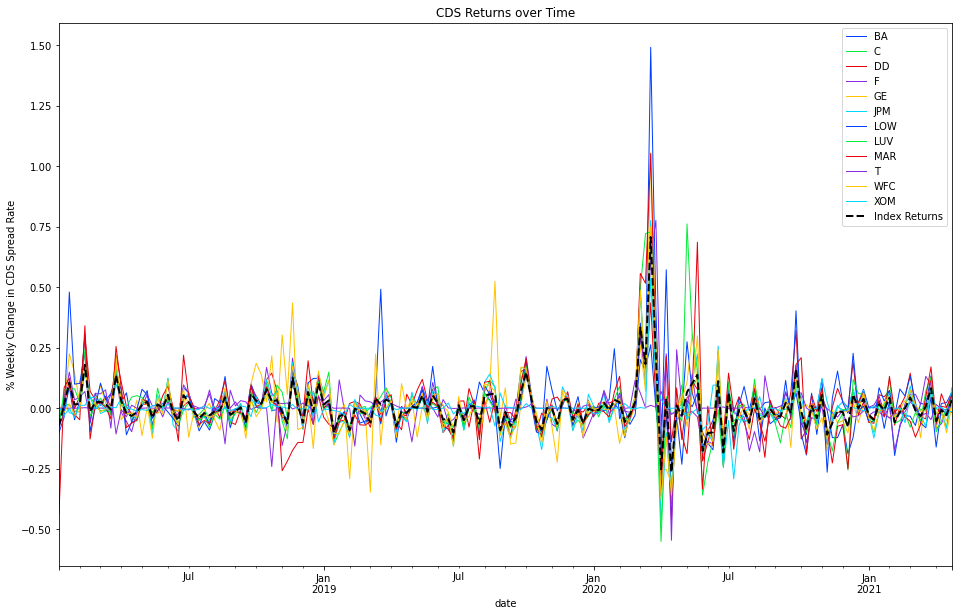

In [8]:
idx_ret = cds_df.mean(axis=1)
cds_df['idx_ret'] = idx_ret
plt.rcParams['figure.figsize'] = [16,10]
cds_df[cds_df.columns.drop('idx_ret')].plot(lw=1)
cds_df['idx_ret'].plot(lw = 2, ls = '--', color = 'black', label = 'Index Returns')
plt.title('CDS Returns over Time')
plt.ylabel("% Weekly Change in CDS Spread Rate")
plt.legend()
plt.show()

Our index seems to be aligned with the data.

In [9]:
qdl_data = {}
for ticker in cds_df.columns[:-1]:
    qdl_data[ticker] = quandl.get('EOD/'+ticker + ".11",start_date = cds_df.index[0], end_date = cds_df.index[-1], api_key = quandl_key)
    qdl_data[ticker].columns = [ticker]
qdl_data['C']

,C
Date,
2018-01-10,68.482990
2018-01-11,68.401516
2018-01-12,69.560250
2018-01-16,69.804671
2018-01-17,70.130565
...,...
2021-04-22,69.313790
2021-04-23,70.872630
2021-04-26,71.686801


In [10]:
tickers_data = pd.concat(qdl_data.values(), axis = 1)
tickers_data = tickers_data.resample("W-Wed").first()
tickers_data.head()

,BA,C,DD,F,GE,JPM,LOW,LUV,MAR,T,WFC,XOM
Date,,,,,,,,,,,,
2018-01-10,305.145884,68.482990,99.438127,11.202605,17.577243,100.064975,88.492575,61.564731,133.545363,29.777801,56.414949,70.780379
2018-01-17,312.634945,68.401516,100.805066,11.314373,17.661745,100.600470,89.967921,63.403068,135.223166,29.663959,56.316634,71.479303
2018-01-24,324.106738,70.058144,101.890577,10.377240,15.572422,102.796907,95.249096,63.618192,136.871874,30.208774,57.156781,71.890434
2018-01-31,326.917518,71.913929,102.721462,9.947363,15.024555,105.011497,100.349101,58.856117,141.110024,30.452721,58.676195,72.663361
2018-02-07,340.094835,71.696666,98.500032,9.624924,14.875981,106.073411,97.971965,58.973458,143.069077,31.843219,58.899638,73.238945


In [11]:
tickers_data = tickers_data.apply(np.log).diff().iloc[1:]

# 2. Model

## 2.1 Comparing OLS/Huber/Tukey for "BA" 

# 2.1.1 OLS

In [12]:
test_date = tickers_data.index[20]

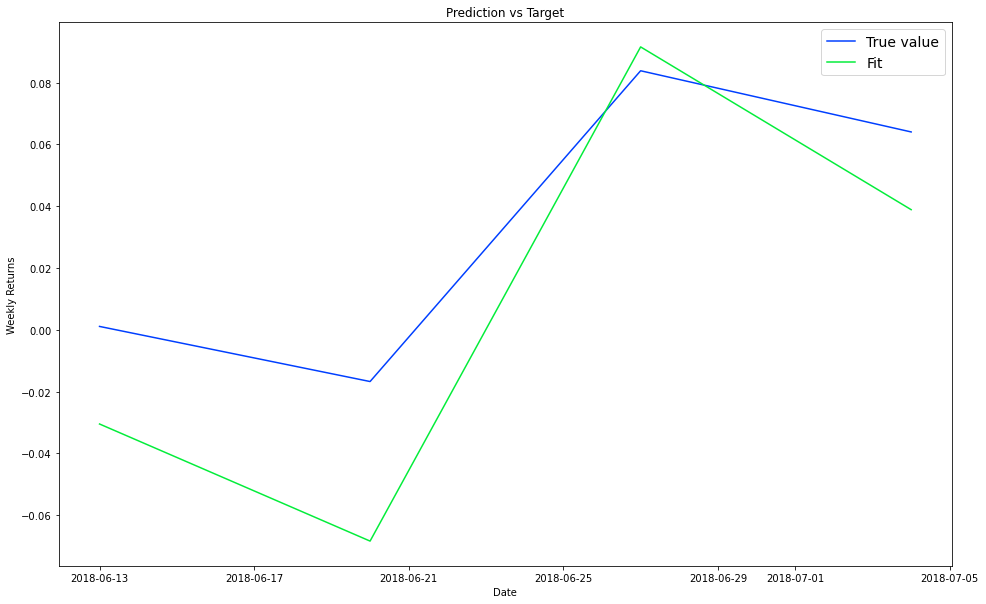

In [13]:
X = pd.concat([tickers_data["BA"],idx_ret],axis = 1)
X_train = X.loc[test_date-timedelta(weeks = 16):test_date]
X_test = X.loc[test_date+timedelta(weeks = 1):test_date+timedelta(weeks = 4)]

y_train = cds_df["BA"].loc[test_date-timedelta(weeks = 16):test_date]
y_test = cds_df["BA"].loc[test_date+timedelta(weeks = 1):test_date+timedelta(weeks = 4)]
model = lm.LinearRegression()
res = model.fit(X_train, y_train)

y_pred = res.predict(X_test)

fig, ax = plt.subplots(figsize = (16,10))
ax.plot(y_test.index, y_test, label = 'True value')
ax.plot(y_test.index, y_pred, label = 'Fit')
ax.set_ylabel("Weekly Returns")
ax.set_xlabel("Date")
ax.set_title("Prediction vs Target")
ax.legend(fontsize = 14)
plt.show()

# 2.1.2 Huber

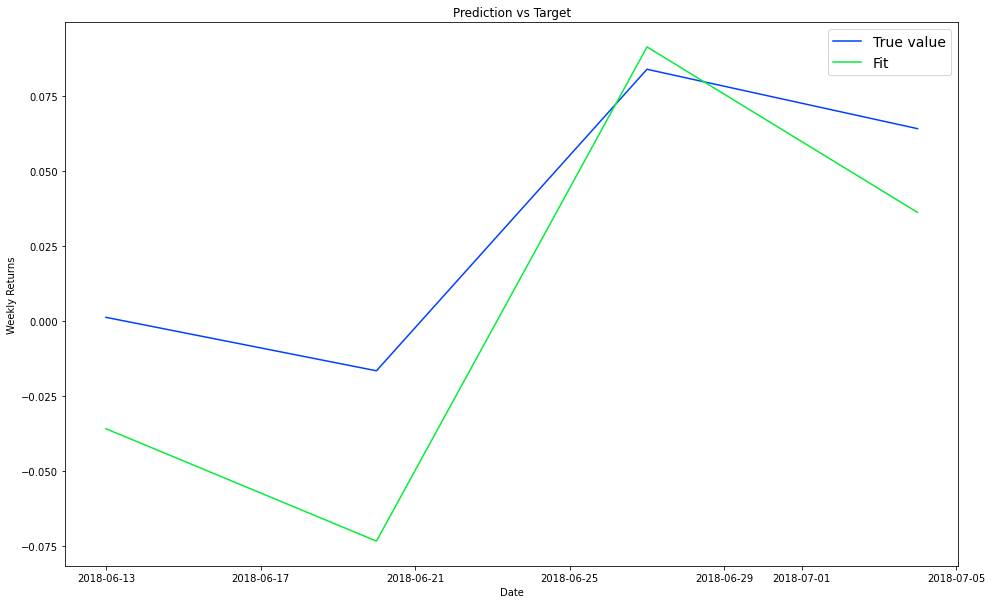

In [14]:
model = sm.RLM(y_train,sm.add_constant(X_train),M=sm.robust.norms.HuberT())
res = model.fit()

y_pred = res.predict(sm.add_constant(X_test))

fig, ax = plt.subplots(figsize = (16,10))
ax.plot(y_test.index, y_test, label = 'True value')
ax.plot(y_test.index, y_pred, label = 'Fit')
ax.set_ylabel("Weekly Returns")
ax.set_xlabel("Date")
ax.set_title("Prediction vs Target")
ax.legend(fontsize = 14)
plt.show()

# 2.1.3 Tukey

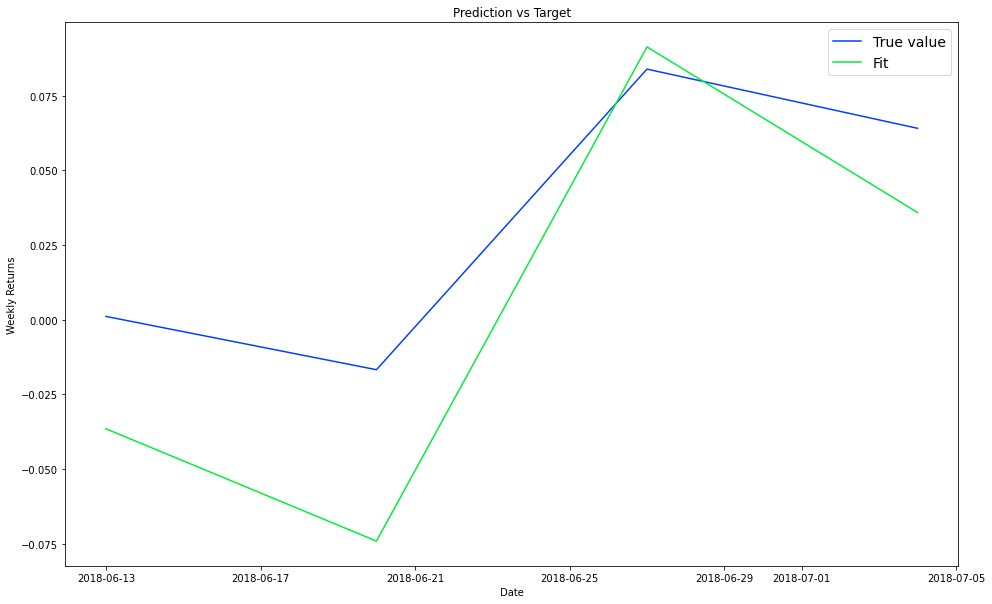

In [15]:
model = sm.RLM(y_train,sm.add_constant(X_train),M=sm.robust.norms.TukeyBiweight())
res = model.fit()

y_pred = res.predict(sm.add_constant(X_test))

fig, ax = plt.subplots(figsize = (16,10))
ax.plot(y_test.index, y_test, label = 'True value')
ax.plot(y_test.index, y_pred, label = 'Fit')
ax.set_ylabel("Weekly Returns")
ax.set_xlabel("Date")
ax.set_title("Prediction vs Target")
ax.legend(fontsize = 14)
plt.show()

These are all similar in implementation. 

In [16]:
def OLS(ticker, test_date, huber = False, tukey = False, intercept = True, to_plot = False, mae = False):
    X = pd.concat([tickers_data[ticker],idx_ret],axis = 1)
    X_train = X.loc[test_date-timedelta(weeks = 16):test_date]
    X_test = X.loc[test_date+timedelta(weeks = 1):test_date+timedelta(weeks = 4)]

    y_train = cds_df[ticker].loc[test_date-timedelta(weeks = 16):test_date]
    y_test = cds_df[ticker].loc[test_date+timedelta(weeks = 1):test_date+timedelta(weeks = 4)] 
    if intercept:
        inter_str = " with intercept"
    else:
        inter_str = " without intercept"
        
    if not huber and not tukey:
        regression_type = "regular OLS"
        if intercept:
            model = lm.LinearRegression()
        else:
            model = lm.LinearRegression(fit_intercept = False)
        res = model.fit(X_train, y_train)
        y_pred = res.predict(X_test)
    else:
        if huber:
            regression_type = "robust Huber penalty function"
            if intercept:
                model = sm.RLM(y_test,sm.add_constant(X_test),M=sm.robust.norms.HuberT())
            else:
                model = sm.RLM(y_test,X_test,M=sm.robust.norms.HuberT())
        else:
            regression_type = "robust Tukey Bisquare penalty function"
            if intercept:
                model = sm.RLM(y_test,sm.add_constant(X_test),M=sm.robust.norms.TukeyBiweight())
            else:
                model = sm.RLM(y_test,X_test,M=sm.robust.norms.TukeyBiweight())
            
        res = model.fit()
        if intercept:
            y_pred = res.predict(sm.add_constant(X_test))
        else:
            y_pred = res.predict(X_test)
        resid = ((y_pred - y_test)**2).sum()
        total = ((y_test - y_test.mean())**2).sum()
    
    if to_plot:
        plt.style.use('ggplot')
        fig, ax = plt.subplots(figsize = (16,10))
        ax.plot(y_test.index, y_test, label = 'True value')
        ax.plot(y_test.index, y_pred, label = 'Fit')
        ax.set_ylabel("Weekly Returns for {}".format(ticker))
        ax.set_xlabel("Date")
        ax.set_title("Prediction vs Target using "+regression_type + inter_str)
        ax.legend(fontsize = 14)
        plt.show()
    if not mae:
        if not huber and not tukey:
            return model.score(X_test,y_test)
        else:
            return 1 - resid/total
    else:
        return  mean_absolute_error(y_pred, y_test)
 

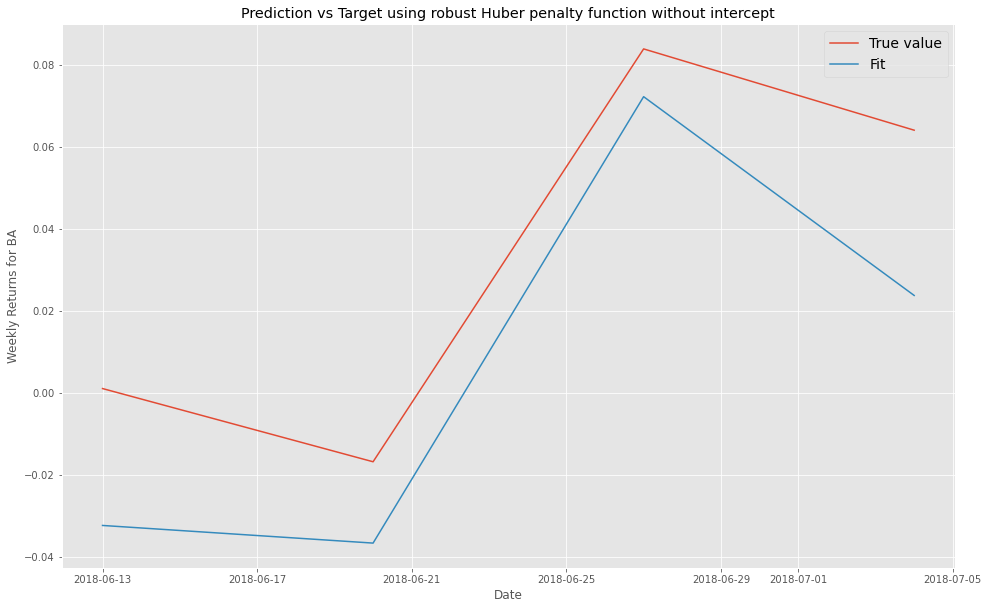

0.5367580137779807

In [17]:
OLS("BA", test_date, huber = True, intercept = False, to_plot = True)

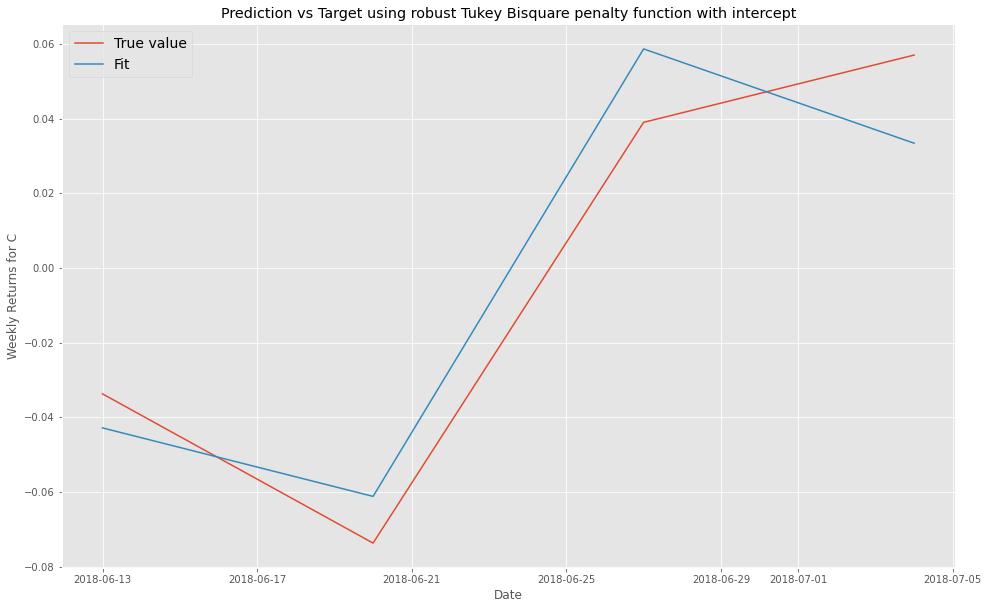

0.01622605438072419

In [18]:
OLS("C", test_date, tukey = True, to_plot = True, mae=True)

Function seems to be flexible and work. Let's apply it to each ticker and get the $R^2$'s. 

# 2.2 Scoring the Regression Methods via $R^2$

In [19]:
cds_df['date'] = cds_df.index

def gen_score_dic(intercept_ = True, mae_ = False):
    dic = {}
    if intercept_:
        str_int = "_w_int"
    else:
        str_int = "_without_int"
    if mae_:
        str_score = "_MAE"
    else:
        str_score = "_R2"
    for ticker in tqdm(cds_df.columns[:-2]):
        
        df1 = cds_df['date'].iloc[17:-4].apply(lambda x : OLS(ticker, x, intercept = intercept_, mae = mae_))
        df1.name = 'OLS' + str_int + str_score
        df1.index = cds_df['date'].iloc[17:-4]
        df2 = cds_df['date'].iloc[17:-4].apply(lambda x: OLS(ticker,x, tukey = True, intercept = intercept_, mae = mae_))
        df2.name = 'Tukey'  + str_int + str_score
        df2.index = cds_df['date'].iloc[17:-4]
        df3 = cds_df['date'].iloc[17:-4].apply(lambda x: OLS(ticker,x,huber = True, intercept = intercept_, mae = mae_))
        df3.name = 'Huber'  + str_int + str_score
        df3.index = cds_df['date'].iloc[17:-4]
        dic[ticker] = pd.concat([df1,df2,df3],axis = 1)
    
    return dic

r2_with_inter_dict = gen_score_dic()
r2_without_inter_dict = gen_score_dic(intercept_ = False)
    
r2_with_inter_dict['BA']

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:34<00:00,  2.85s/it]


,OLS_w_int_R2,Tukey_w_int_R2,Huber_w_int_R2
date,,,
2018-05-09,0.691036,0.967198,0.967232
2018-05-16,-2.089609,0.995478,0.995479
2018-05-23,-1.630824,0.993703,0.993706
2018-05-30,0.187212,0.952671,0.952693
2018-06-06,0.381225,0.975389,0.975441
...,...,...,...
2021-03-03,-1.058034,0.891587,0.891621
2021-03-10,-0.848915,0.989900,0.986339
2021-03-17,0.250591,0.980316,0.972829


In [20]:
def concat_dic_to_df(dic):
    for t, df in dic.items():
        multi_idx_tup = [(t,c) for c in df.columns]
        idx = pd.MultiIndex.from_tuples(multi_idx_tup)
        df.columns = idx
        
    df = pd.concat(dic.values(), axis = 1)
    df.columns.names = ['ticker','regress_type']
    return df
r2_with_inter_df = concat_dic_to_df(r2_with_inter_dict)
r2_without_inter_df = concat_dic_to_df(r2_without_inter_dict)
r2_with_inter_df.head()

ticker                 BA                                          C  \
regress_type OLS_w_int_R2 Tukey_w_int_R2 Huber_w_int_R2 OLS_w_int_R2   
date                                                                   
2018-05-09       0.691036       0.967198       0.967232     0.405990   
2018-05-16      -2.089609       0.995478       0.995479     0.182595   
2018-05-23      -1.630824       0.993703       0.993706     0.716451   
2018-05-30       0.187212       0.952671       0.952693     0.709170   
2018-06-06       0.381225       0.975389       0.975441     0.805913   

ticker                                               DD                 \
regress_type Tukey_w_int_R2 Huber_w_int_R2 OLS_w_int_R2 Tukey_w_int_R2   
date                                                                     
2018-05-09         0.899786       0.899787    -0.836781       0.982821   
2018-05-16         0.888621       0.852148    -2.084461       0.964544   
2018-05-23         0.977203       0.968587    -0.084474       0.997516   
2018-05-30         0.947578       0.947590    -1.768782       0.890524   
2018-06-06         0.895322       0.895382    -1.975150       0.899951   

ticker                                 F  ...            MAR            T  \
regress_type Huber_w_int_R2 OLS_w_int_R2  ... Huber_w_int_R2 OLS_w_int_R2   
date                                      ...                               
2018-05-09         0.982839    -0.087649  ...       0.735041 -1539.200423   
2018-05-16         0.951338     0.669268  ...       0.363567  -583.733107   
2018-05-23         0.997523     0.693835  ...       0.862390 -1389.850571   
2018-05-30         0.890563     0.732085  ...       0.847723  -261.802243   
2018-06-06         0.900700     0.692864  ...       0.989443   -27.442575   

ticker                                              WFC                 \
regress_type Tukey_w_int_R2 Huber_w_int_R2 OLS_w_int_R2 Tukey_w_int_R2   
date                                                                     
2018-05-09         0.959258       0.945310     0.613110       0.987820   
2018-05-16         0.517256       0.299438     0.431743       0.943737   
2018-05-23         0.818642       0.754523     0.803734       0.956968   
2018-05-30         0.164895       0.165203     0.828961       0.899323   
2018-06-06         0.301518       0.302854     0.902446       0.992525   

ticker                               XOM                                
regress_type Huber_w_int_R2 OLS_w_int_R2 Tukey_w_int_R2 Huber_w_int_R2  
date                                                                    
2018-05-09         0.987853    -3.085174       0.834846       0.777829  
2018-05-16         0.944178    -0.352319       0.805844       0.729327  
2018-05-23         0.940690     0.491995       0.826244       0.826270  
2018-05-30         0.899364     0.001922       0.553316       0.553419  
2018-06-06         0.992537    -6.240530       0.994349       0.994356  

[5 rows x 36 columns]

In [21]:
r2_without_inter_df.head()

ticker                       BA                                            \
regress_type OLS_without_int_R2 Tukey_without_int_R2 Huber_without_int_R2   
date                                                                        
2018-05-09             0.691072             0.860459             0.860528   
2018-05-16            -2.137292             0.984812             0.984451   
2018-05-23            -1.583953             0.668627             0.668726   
2018-05-30             0.070303             0.763339             0.701306   
2018-06-06             0.289695             0.536576             0.536758   

ticker                        C                                            \
regress_type OLS_without_int_R2 Tukey_without_int_R2 Huber_without_int_R2   
date                                                                        
2018-05-09             0.438132             0.911283             0.912924   
2018-05-16             0.329480             0.849788             0.850224   
2018-05-23             0.732389             0.976722             0.976750   
2018-05-30             0.715008             0.939340             0.939388   
2018-06-06             0.804008             0.884012             0.884040   

ticker                       DD                                            \
regress_type OLS_without_int_R2 Tukey_without_int_R2 Huber_without_int_R2   
date                                                                        
2018-05-09            -0.695399             0.950782             0.950788   
2018-05-16            -0.602178             0.937821             0.937841   
2018-05-23            -0.348410             0.983655             0.983663   
2018-05-30            -1.399863             0.878141             0.878395   
2018-06-06            -1.784691             0.872738             0.872774   

ticker                        F  ...                  MAR                  T  \
regress_type OLS_without_int_R2  ... Huber_without_int_R2 OLS_without_int_R2   
date                             ...                                           
2018-05-09            -0.068488  ...             0.488180       -1373.383007   
2018-05-16             0.674127  ...             0.316130        -715.733553   
2018-05-23             0.708352  ...             0.889056       -1301.463141   
2018-05-30             0.737763  ...             0.831058        -246.072670   
2018-06-06             0.727205  ...             0.897303         -25.826647   

ticker                                                                WFC  \
regress_type Tukey_without_int_R2 Huber_without_int_R2 OLS_without_int_R2   
date                                                                        
2018-05-09              -2.207613            -2.197318           0.596234   
2018-05-16               0.282822             0.283223           0.526694   
2018-05-23               0.267500             0.268060           0.790690   
2018-05-30               0.117091             0.117771           0.843504   
2018-06-06              -0.473744            -0.412235           0.910875   

ticker                                                                XOM  \
regress_type Tukey_without_int_R2 Huber_without_int_R2 OLS_without_int_R2   
date                                                                        
2018-05-09               0.987237             0.987232          -3.349366   
2018-05-16               0.943683             0.943776          -0.708449   
2018-05-23               0.952812             0.952812           0.177026   
2018-05-30               0.899263             0.899279           0.086808   
2018-06-06               0.947451             0.947453          -4.918540   

ticker                                                  
regress_type Tukey_without_int_R2 Huber_without_int_R2  
date                                                    
2018-05-09               0.186605             0.186952  
2018-05-16               0.508147             

# 2.3 Scoring Regression via MAE

In [22]:
mae_with_inter_dict = gen_score_dic(mae_ = True)
mae_without_inter_dict = gen_score_dic(intercept_ = False, mae_ = True)
    
mae_with_inter_dict['BA']

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:38<00:00,  3.24s/it]


,OLS_w_int_MAE,Tukey_w_int_MAE,Huber_w_int_MAE
date,,,
2018-05-09,0.019981,0.007340,0.007420
2018-05-16,0.029606,0.001184,0.001189
2018-05-23,0.038630,0.001563,0.001584
2018-05-30,0.032673,0.008306,0.008350
2018-06-06,0.029020,0.005643,0.005740
...,...,...,...
2021-03-03,0.086937,0.018965,0.019218
2021-03-10,0.081666,0.005958,0.004289
2021-03-17,0.053028,0.008206,0.006050


In [23]:
mae_with_inter_df = concat_dic_to_df(mae_with_inter_dict)
mae_without_inter_df = concat_dic_to_df(mae_without_inter_dict)
mae_with_inter_df.head()

ticker                  BA                                             C  \
regress_type OLS_w_int_MAE Tukey_w_int_MAE Huber_w_int_MAE OLS_w_int_MAE   
date                                                                       
2018-05-09        0.019981        0.007340        0.007420      0.053127   
2018-05-16        0.029606        0.001184        0.001189      0.042104   
2018-05-23        0.038630        0.001563        0.001584      0.024739   
2018-05-30        0.032673        0.008306        0.008350      0.028961   
2018-06-06        0.029020        0.005643        0.005740      0.021344   

ticker                                                  DD                  \
regress_type Tukey_w_int_MAE Huber_w_int_MAE OLS_w_int_MAE Tukey_w_int_MAE   
date                                                                         
2018-05-09          0.012797        0.012797      0.026254        0.002629   
2018-05-16          0.016902        0.012145      0.024056        0.002560   
2018-05-23          0.008500        0.006609      0.026041        0.001235   
2018-05-30          0.016589        0.016640      0.046156        0.007995   
2018-06-06          0.016226        0.016347      0.041862        0.006645   

ticker                                   F  ...             MAR             T  \
regress_type Huber_w_int_MAE OLS_w_int_MAE  ... Huber_w_int_MAE OLS_w_int_MAE   
date                                        ...                                 
2018-05-09          0.002657      0.023101  ...        0.016590      0.006566   
2018-05-16          0.001854      0.014393  ...        0.016643      0.004398   
2018-05-23          0.001260      0.010107  ...        0.015961      0.011946   
2018-05-30          0.008102      0.016011  ...        0.046107      0.012970   
2018-06-06          0.006859      0.022087  ...        0.013006      0.011772   

ticker                                                 WFC                  \
regress_type Tukey_w_int_MAE Huber_w_int_MAE OLS_w_int_MAE Tukey_w_int_MAE   
date                                                                         
2018-05-09          0.000036        0.000026      0.049467        0.007704   
2018-05-16          0.000137        0.000104      0.034120        0.011318   
2018-05-23          0.000139        0.000117      0.020496        0.011754   
2018-05-30          0.000718        0.000727      0.019981        0.017385   
2018-06-06          0.002151        0.002186      0.011859        0.003294   

ticker                                 XOM                                  
regress_type Huber_w_int_MAE OLS_w_int_MAE Tukey_w_int_MAE Huber_w_int_MAE  
date                                                                        
2018-05-09          0.007855      0.010104        0.001890        0.001361  
2018-05-16          0.011686      0.006753        0.002551        0.001867  
2018-05-23          0.008565      0.003206        0.002701        0.002706  
2018-05-30          0.017593      0.006832        0.005935        0.005952  
2018-06-06          0.003349      0.008840        0.000270        0.000274  

[5 rows x 36 columns]

In [24]:
mae_without_inter_df.head()

ticker                        BA                                              \
regress_type OLS_without_int_MAE Tukey_without_int_MAE Huber_without_int_MAE   
date                                                                           
2018-05-09              0.019965              0.015335              0.015409   
2018-05-16              0.029556              0.001365              0.001349   
2018-05-23              0.038333              0.012827              0.012921   
2018-05-30              0.033237              0.015645              0.012808   
2018-06-06              0.030330              0.026109              0.026263   

ticker                         C                                              \
regress_type OLS_without_int_MAE Tukey_without_int_MAE Huber_without_int_MAE   
date                                                                           
2018-05-09              0.053731              0.014547              0.014594   
2018-05-16              0.043162              0.012523              0.012483   
2018-05-23              0.027205              0.010179              0.010231   
2018-05-30              0.031757              0.016855              0.016945   
2018-06-06              0.021705              0.016320              0.016350   

ticker                        DD                                              \
regress_type OLS_without_int_MAE Tukey_without_int_MAE Huber_without_int_MAE   
date                                                                           
2018-05-09              0.024130              0.004633              0.004644   
2018-05-16              0.017975              0.003959              0.003975   
2018-05-23              0.028536              0.003530              0.003533   
2018-05-30              0.041344              0.008941              0.009115   
2018-06-06              0.038593              0.008831              0.008869   

ticker                         F  ...                   MAR  \
regress_type OLS_without_int_MAE  ... Huber_without_int_MAE   
date                              ...                         
2018-05-09              0.022984  ...              0.032834   
2018-05-16              0.014441  ...              0.030804   
2018-05-23              0.009828  ...              0.019733   
2018-05-30              0.015562  ...              0.046836   
2018-06-06              0.019801  ...              0.036767   

ticker                         T                                              \
regress_type OLS_without_int_MAE Tukey_without_int_MAE Huber_without_int_MAE   
date                                                                           
2018-05-09              0.007156              0.000359              0.000367   
2018-05-16              0.005026              0.000197              0.000198   
2018-05-23              0.012420              0.000306              0.000305   
2018-05-30              0.013297              0.000758              0.000762   
2018-06-06              0.012251              0.002316              0.002311   

ticker                       WFC                                              \
regress_type OLS_without_int_MAE Tukey_without_int_MAE Huber_without_int_MAE   
date                                                                           
2018-05-09              0.051027              0.007418              0.007468   
2018-05-16              0.032799              0.011297              0.011345   
2018-05-23              0.026833              0.014730              0.014737   
2018-05-30              0.022158              0.017396              0.017577   
2018-06-06              0.011029              0.009702              0.009697   

ticker                       XOM                                              
regress_type OLS_without_int_MAE Tukey_without_int_MAE Huber_without_int_MAE  
date                                                                          
2018-05-09              0.010632              0.00419

# 3. Analysis

# 3.1 Analysis under $R^2$

## 3.1.1 Distribution of the score

In [25]:
df1 = r2_with_inter_df.xs('OLS_w_int_R2',level = 'regress_type',axis =1).mean()
df2 = r2_with_inter_df.xs('Huber_w_int_R2',level = 'regress_type',axis =1).mean()
df3 = r2_with_inter_df.xs('Tukey_w_int_R2',level = 'regress_type',axis =1).mean()
df4 = r2_without_inter_df.xs('OLS_without_int_R2',level = 'regress_type',axis =1).mean()
df5 = r2_without_inter_df.xs('Huber_without_int_R2',level = 'regress_type',axis =1).mean()
df6 = r2_without_inter_df.xs('Tukey_without_int_R2',level = 'regress_type',axis =1).mean()

mean_df = pd.concat([df1,df2,df3,df4,df5,df6],axis = 1)
mean_df.columns = 'OLS Huber Tukey OLS-no-int Huber-no-int Tukey-no-int'.split()
mean_df


,OLS,Huber,Tukey,OLS-no-int,Huber-no-int,Tukey-no-int
ticker,,,,,,
BA,-0.853826,0.833691,0.848864,-0.603362,0.635624,0.632305
C,0.248067,0.901485,0.909161,0.367429,0.769364,0.771385
DD,-1.788623,0.814150,0.831278,-1.755698,-0.056423,-0.065343
F,-0.387427,0.812571,0.826306,-0.230156,0.574842,0.571003
GE,-0.782507,0.858147,0.871938,-0.691947,0.631192,0.631214
JPM,0.342319,0.901021,0.908717,0.475868,0.782030,0.779258
LOW,-0.342879,0.866911,0.877212,-0.177635,0.678355,0.679852
LUV,-0.146765,0.884484,0.893004,0.046149,0.725286,0.721695
MAR,-0.066224,0.828404,0.844923,0.047436,0.624476,0.622814


In [26]:
df1 = r2_with_inter_df.xs('OLS_w_int_R2',level = 'regress_type',axis =1).std()
df2 = r2_with_inter_df.xs('Huber_w_int_R2',level = 'regress_type',axis =1).std()
df3 = r2_with_inter_df.xs('Tukey_w_int_R2',level = 'regress_type',axis =1).std()
df4 = r2_without_inter_df.xs('OLS_without_int_R2',level = 'regress_type',axis =1).std()
df5 = r2_without_inter_df.xs('Huber_without_int_R2',level = 'regress_type',axis =1).std()
df6 = r2_without_inter_df.xs('Tukey_without_int_R2',level = 'regress_type',axis =1).std()

std_df = pd.concat([df1,df2,df3,df4,df5,df6],axis = 1)
std_df.columns = 'OLS Huber Tukey OLS-no-int Huber-no-int Tukey-no-int'.split()
std_df

,OLS,Huber,Tukey,OLS-no-int,Huber-no-int,Tukey-no-int
ticker,,,,,,
BA,4.243544,0.260588,0.231850,3.139831,0.570901,0.588277
C,1.725325,0.177339,0.162619,1.332864,0.441764,0.437736
DD,7.894460,0.266280,0.234529,10.271235,3.586424,3.606458
F,2.555062,0.266234,0.253873,2.118777,0.606864,0.626045
GE,2.876033,0.223841,0.192399,2.743518,0.650648,0.652598
JPM,1.402588,0.138815,0.130211,0.940443,0.400030,0.406993
LOW,3.458083,0.209333,0.192607,2.627105,0.427729,0.422513
LUV,2.567842,0.185148,0.179601,2.462265,0.352002,0.362475
MAR,1.936826,0.232853,0.208328,1.580528,0.745262,0.757209


The regular OLS with or without intercept a really inconsistent and bad scoring for predicting CDS returns and generally scores negative. This mean that OLS does worse than forecasting without a model which is a good indicator that it doesn't give us any additional relevant or material information. Considering we don't expect returns to be higher or lower than 0, it makes sense that adding an intercept to OLS doesn't really improve anything here.

Interesting here is how well the robust regressions perform in the context of "XOM" and "T" where in both cases OLS hs a horrible performance. Seems like a good case study for the robustness of the model.

## 3.1.2 Case study: XOM & T

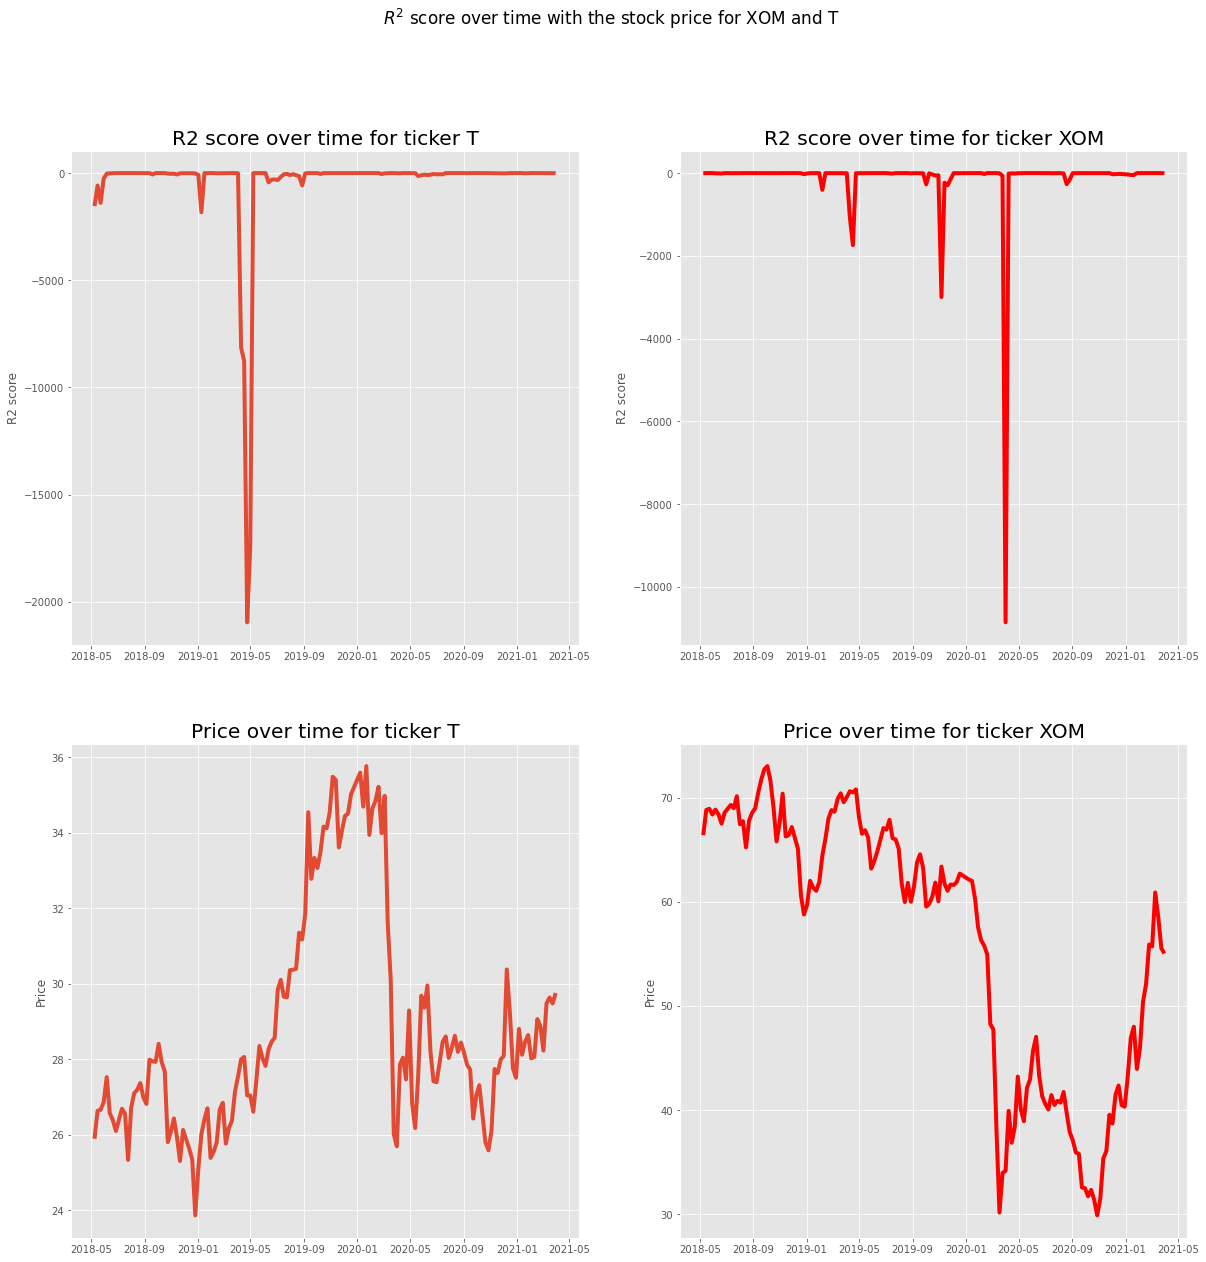

In [27]:
fig, axes = plt.subplots(2,2,figsize =(20,20))
plt.style.use('fivethirtyeight')
plt.suptitle("$R^{2}$ score over time with the stock price for XOM and T")

axes[0][0].plot(r2_with_inter_df.xs("T", level = 'ticker', axis=1)['OLS_w_int_R2'])
axes[0][0].set_ylabel('R2 score')
axes[0][0].set_title("R2 score over time for ticker T")

data = qdl_data["T"][qdl_data["T"].index.isin(r2_with_inter_df.xs("T", level = 'ticker', axis=1)['OLS_w_int_R2'].index)]
axes[1][0].plot(data)
axes[1][0].set_ylabel('Price')
axes[1][0].set_title("Price over time for ticker T")

axes[0][1].plot(r2_with_inter_df.xs("XOM", level = 'ticker', axis=1)['OLS_w_int_R2'], color = 'red')
axes[0][1].set_ylabel('R2 score')
axes[0][1].set_title("R2 score over time for ticker XOM")

data = qdl_data["XOM"][qdl_data["XOM"].index.isin(r2_with_inter_df.xs("XOM", level = 'ticker', axis=1)['OLS_w_int_R2'].index)]
axes[1][1].plot(data, color = 'red')
axes[1][1].set_ylabel('Price')
axes[1][1].set_title("Price over time for ticker XOM")
plt.show()

Interestingly the dip in the $R^2$ for AT&T corresponds to a moment where the stock price was rising quickly from early 2019 to early 2020 then it crashed but the negative peak occurs in May 2019. While for Exxon, the dip in the $R^2$ score correlates more with a drastic price change early 2020 when the stock dipped. It would make sense for big change in the stock price to completely shater the $R^2$ as we see here.

## 3.1.3 Intercept vs No-Intercept

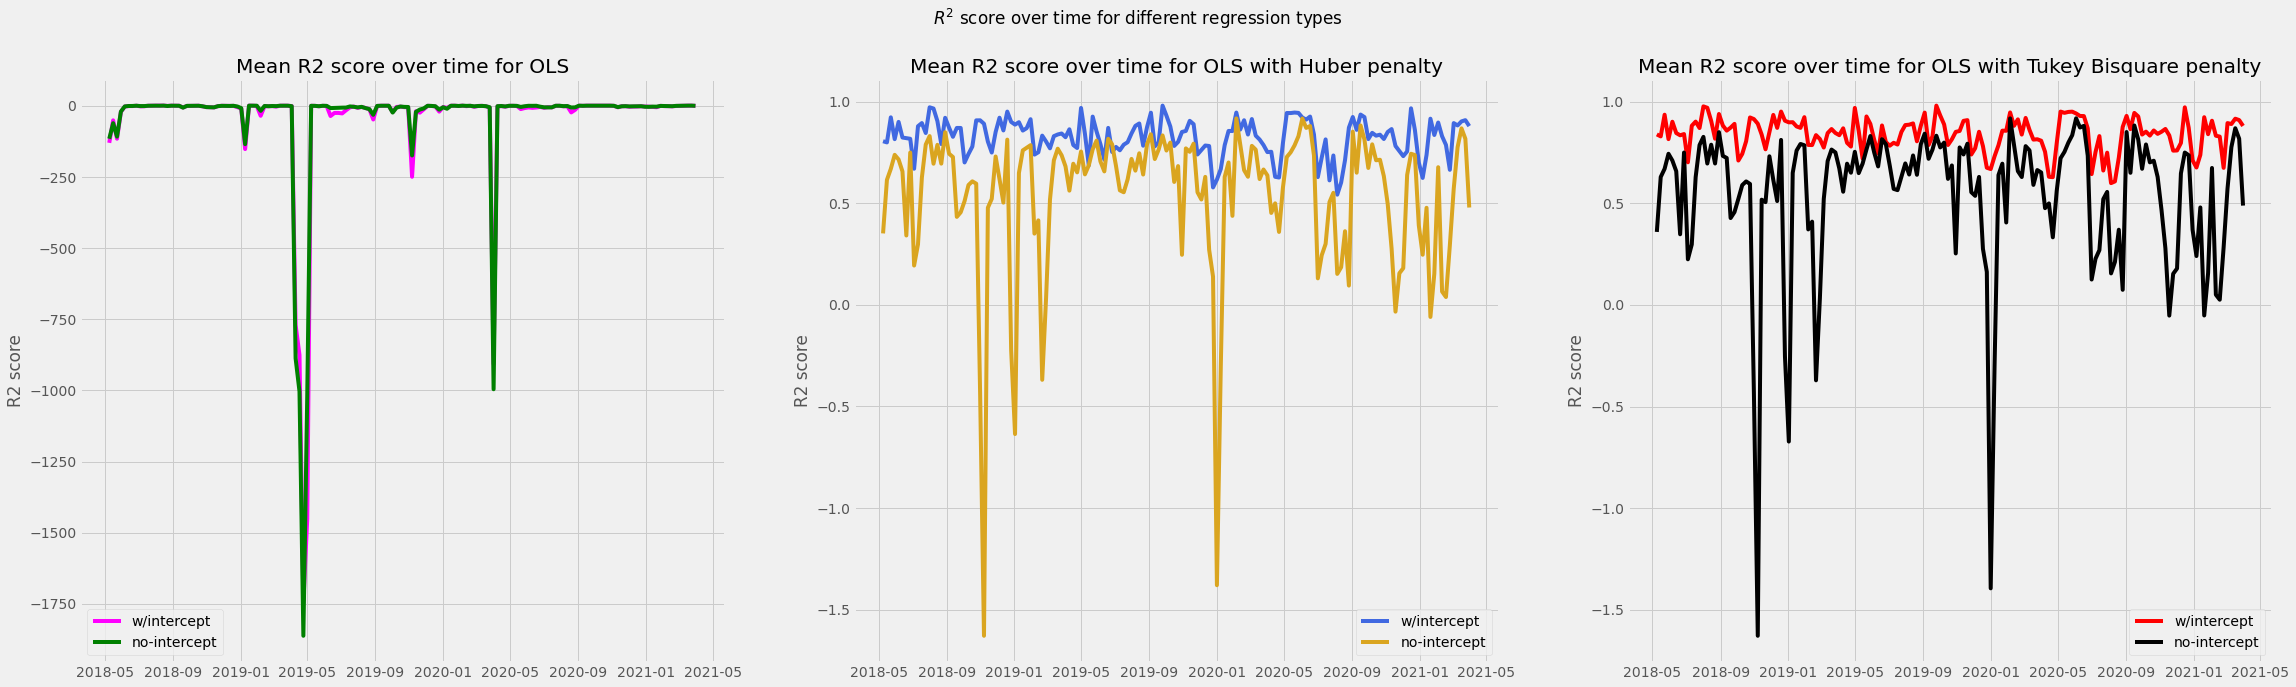

In [28]:
df1 = r2_with_inter_df.xs('OLS_w_int_R2',level = 'regress_type',axis =1).mean(axis =1 )
df2 = r2_with_inter_df.xs('Huber_w_int_R2',level = 'regress_type',axis =1).mean(axis=1)
df3 = r2_with_inter_df.xs('Tukey_w_int_R2',level = 'regress_type',axis =1).mean(axis=1)
df4 = r2_without_inter_df.xs('OLS_without_int_R2',level = 'regress_type',axis =1).mean(axis=1)
df5 = r2_without_inter_df.xs('Huber_without_int_R2',level = 'regress_type',axis =1).mean(axis=1)
df6 = r2_without_inter_df.xs('Tukey_without_int_R2',level = 'regress_type',axis =1).mean(axis=1)

fig, axes = plt.subplots(1,3,figsize =(35,10))
plt.style.use('seaborn-bright')
plt.suptitle("$R^{2}$ score over time for different regression types ")

axes[0].plot(df1,  c = 'magenta', label = 'w/intercept')
axes[0].plot(df4,  c = 'green', label = 'no-intercept')
axes[0].set_ylabel('R2 score')
axes[0].set_title("Mean R2 score over time for OLS")
axes[0].legend(fontsize= 14)

axes[1].plot(df2,  c = 'royalblue', label = 'w/intercept')
axes[1].plot(df5,  c = 'goldenrod', label = 'no-intercept')
axes[1].set_ylabel('R2 score')
axes[1].set_title("Mean R2 score over time for OLS with Huber penalty")
axes[1].legend(fontsize= 14)

axes[2].plot(df3,  c = 'red', label = 'w/intercept')
axes[2].plot(df6,  c = 'k', label = 'no-intercept')
axes[2].set_ylabel('R2 score')
axes[2].set_title("Mean R2 score over time for OLS with Tukey Bisquare penalty")
axes[2].legend(fontsize= 14)

plt.show()

The OLS case is so absurd in its distribution of the $R^2$ scores that it is difficult to analyze. For the other two robust regerssion techniques deployed in this exercise, it looks like using an intercept has a significant advantage in the $R^2$ score over time. Let's look at Huber vs Tukey in this case.

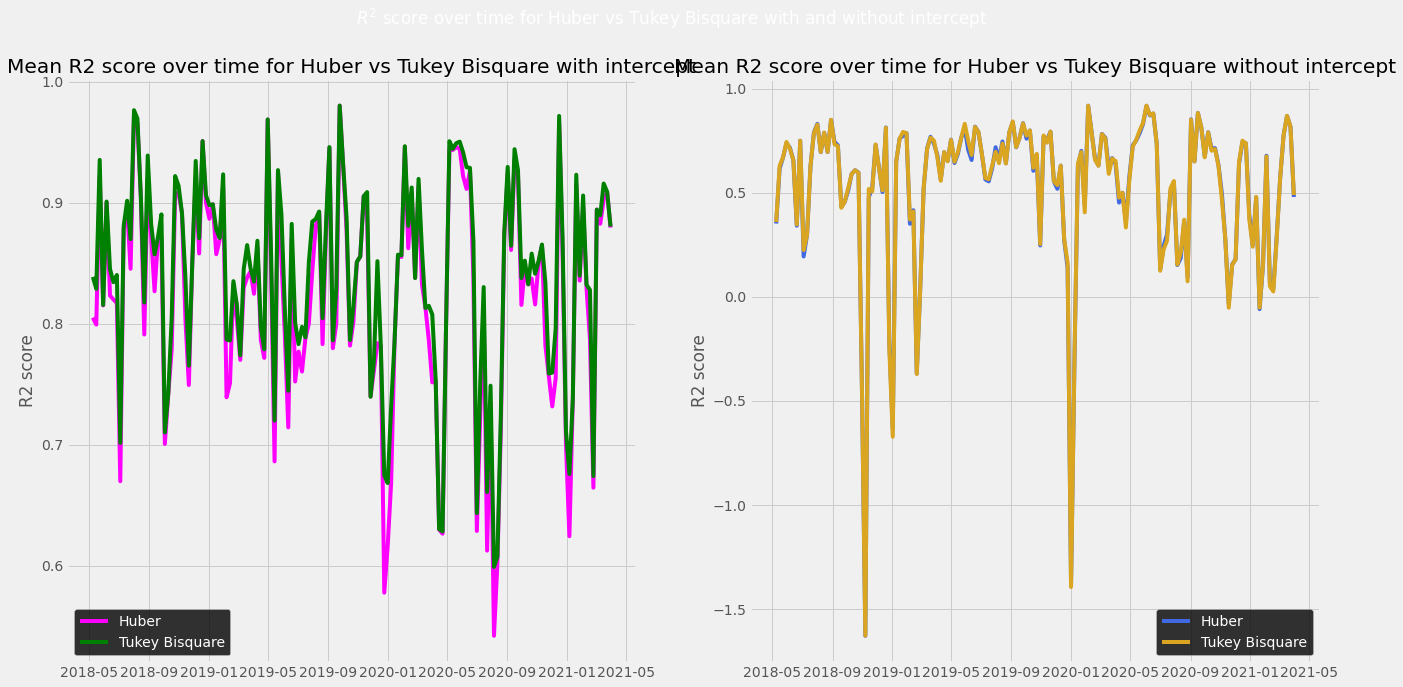

In [29]:
fig, axes = plt.subplots(1,2,figsize =(20,10))
plt.style.use('dark_background')
plt.suptitle("$R^{2}$ score over time for Huber vs Tukey Bisquare with and without intercept ")

axes[0].plot(df2,  c = 'magenta', label = 'Huber')
axes[0].plot(df3,  c = 'green', label = 'Tukey Bisquare')
axes[0].set_ylabel('R2 score')
axes[0].set_title("Mean R2 score over time for Huber vs Tukey Bisquare with intercept")
axes[0].legend(fontsize= 14)

axes[1].plot(df5,  c = 'royalblue', label = 'Huber')
axes[1].plot(df6,  c = 'goldenrod', label = 'Tukey Bisquare')
axes[1].set_ylabel('R2 score')
axes[1].set_title("Mean R2 score over time for Huber vs Tukey Bisquare without intercept")
axes[1].legend(fontsize= 14)

plt.show()

Difficult to compare, let's look at the spread of Tukey - Hubey for a closer look at the difference of the two. 

No handles with labels found to put in legend.
No handles with labels found to put in legend.


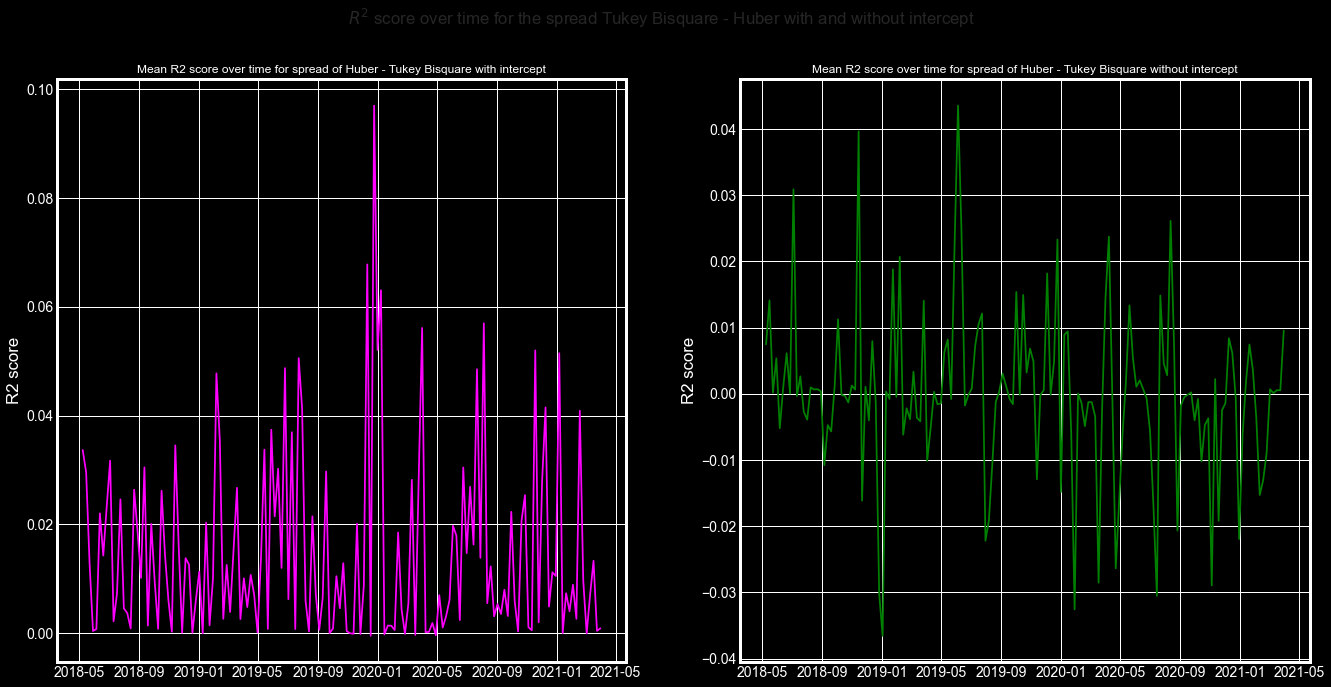

In [30]:
fig, axes = plt.subplots(1,2,figsize =(20,10))
plt.style.use('seaborn')
plt.suptitle("$R^{2}$ score over time for the spread Tukey Bisquare - Huber with and without intercept ")

axes[0].plot(df3 -df2,  c = 'magenta')
axes[0].set_ylabel('R2 score')
axes[0].set_title("Mean R2 score over time for spread of Huber - Tukey Bisquare with intercept")
axes[0].legend(fontsize= 14)

axes[1].plot(df6-df5,  c = 'green')
axes[1].set_ylabel('R2 score')
axes[1].set_title("Mean R2 score over time for spread of Huber - Tukey Bisquare without intercept")
axes[1].legend(fontsize= 14)

plt.show()

It looks like in the case of  intercept, that the Tukey Bisquare outperforms the Huber penalty in terms of $R^2$ score but for the without intercept case, we do not have a clear better penalty. Let's look at individual tickers performs for their $R^2$ between Tukey Bisquare and Huber.

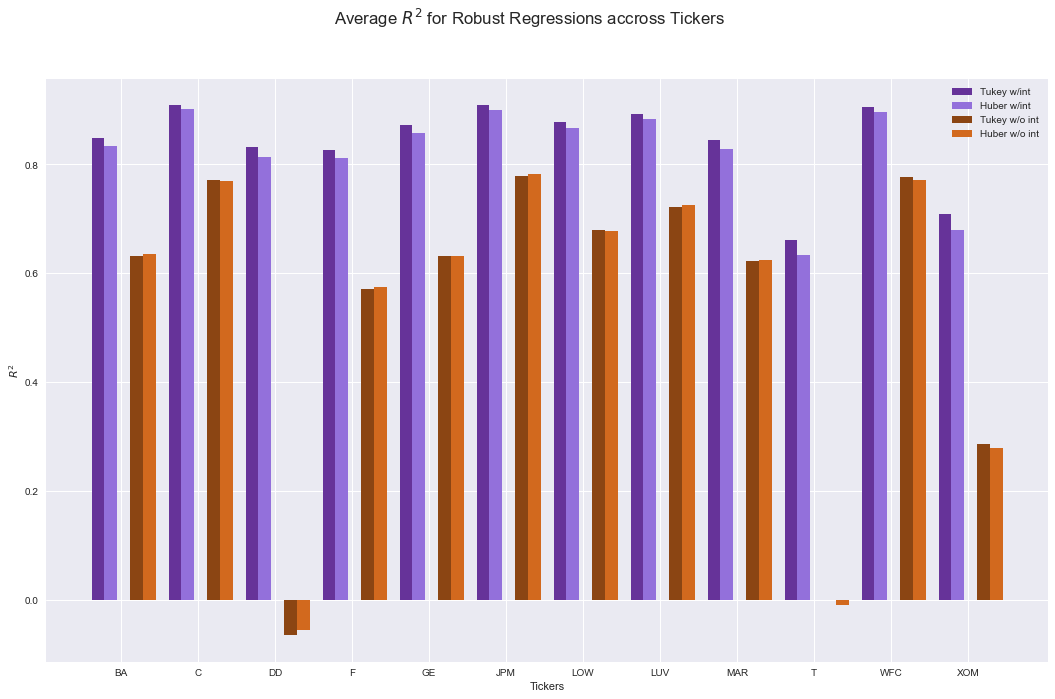

In [31]:
plt.style.use('seaborn-bright')
fig, axes = plt.subplots(1,1,figsize =(16,10))
fig.suptitle('Average $R^2$ for Robust Regressions accross Tickers')
df1 = r2_with_inter_df.xs('OLS_w_int_R2',level = 'regress_type',axis =1).mean(axis =0 )
df2 = r2_with_inter_df.xs('Huber_w_int_R2',level = 'regress_type',axis =1).mean(axis=0)
df3 = r2_with_inter_df.xs('Tukey_w_int_R2',level = 'regress_type',axis =1).mean(axis=0)
df4 = r2_without_inter_df.xs('OLS_without_int_R2',level = 'regress_type',axis =1).mean(axis=0)
df5 = r2_without_inter_df.xs('Huber_without_int_R2',level = 'regress_type',axis =1).mean(axis=0)
df6 = r2_without_inter_df.xs('Tukey_without_int_R2',level = 'regress_type',axis =1).mean(axis=0)

tickers = df1.index
ind = np.arange(len(tickers)) 
width = 1/6

bar1 = plt.bar(ind, df3,width,label = 'Tukey w/int',color = 'rebeccapurple')
bar2 = plt.bar(ind+width, df2, width,label = 'Huber w/int',color='mediumpurple')

bar3 = plt.bar(ind+width*3, df6, width,label = 'Tukey w/o int',color='saddlebrown')
bar4 = plt.bar(ind+width*4, df5, width,label = 'Huber w/o int',color = 'chocolate')

plt.xlabel("Tickers")
plt.ylabel('$R^2$')

plt.xticks(ind+.3,tickers)
plt.legend()
axes.legend()
plt.show()


In [32]:
df3

ticker
BA     0.848864
C      0.909161
DD     0.831278
F      0.826306
GE     0.871938
JPM    0.908717
LOW    0.877212
LUV    0.893004
MAR    0.844923
T      0.662118
WFC    0.905776
XOM    0.708759
dtype: float64

Clearly the intercept here improves drastically the perform of robust regressions, espcially when looking at DD, T, XOM where the $R^2$ is magnitured lower without intercept.

## 3.1.4 DuPont Case Study 

Seems like both Tuckey and Huber performed badly for Dupont without intercept.

# 3.2 Analysis under MAE

## 3.2.1 Distribution of Score

In [33]:
df1 = mae_with_inter_df.xs('OLS_w_int_MAE',level = 'regress_type',axis =1).mean()
df2 = mae_with_inter_df.xs('Huber_w_int_MAE',level = 'regress_type',axis =1).mean()
df3 = mae_with_inter_df.xs('Tukey_w_int_MAE',level = 'regress_type',axis =1).mean()
df4 = mae_without_inter_df.xs('OLS_without_int_MAE',level = 'regress_type',axis =1).mean()
df5 = mae_without_inter_df.xs('Huber_without_int_MAE',level = 'regress_type',axis =1).mean()
df6 = mae_without_inter_df.xs('Tukey_without_int_MAE',level = 'regress_type',axis =1).mean()

mean_df = pd.concat([df1,df2,df3,df4,df5,df6],axis = 1)
mean_df.columns = 'OLS Huber Tukey OLS-no-int Huber-no-int Tukey-no-int'.split()
mean_df.loc['mean'] = mean_df.mean()
mean_df

,OLS,Huber,Tukey,OLS-no-int,Huber-no-int,Tukey-no-int
ticker,,,,,,
BA,0.065275,0.015219,0.015654,0.062729,0.025535,0.025626
C,0.031455,0.009510,0.009887,0.029665,0.016402,0.016424
DD,0.056669,0.016040,0.016489,0.054798,0.029194,0.029168
F,0.049579,0.016899,0.017623,0.047373,0.027645,0.027610
GE,0.063429,0.018515,0.019017,0.061377,0.029472,0.029555
JPM,0.035091,0.012481,0.012892,0.032336,0.019524,0.019458
LOW,0.047614,0.016366,0.017172,0.047518,0.026341,0.026417
LUV,0.050445,0.016473,0.016924,0.045041,0.027361,0.027221
MAR,0.049540,0.017556,0.018268,0.047415,0.027081,0.027162


Looking at the mean of each regression type, MAE for OLS is around twice as much mean absolute error than the other regerssion techniques

In [34]:
df1 = mae_with_inter_df.xs('OLS_w_int_MAE',level = 'regress_type',axis =1).std()
df2 = mae_with_inter_df.xs('Huber_w_int_MAE',level = 'regress_type',axis =1).std()
df3 = mae_with_inter_df.xs('Tukey_w_int_MAE',level = 'regress_type',axis =1).std()
df4 = mae_without_inter_df.xs('OLS_without_int_MAE',level = 'regress_type',axis =1).std()
df5 = mae_without_inter_df.xs('Huber_without_int_MAE',level = 'regress_type',axis =1).std()
df6 = mae_without_inter_df.xs('Tukey_without_int_MAE',level = 'regress_type',axis =1).std()

std_df = pd.concat([df1,df2,df3,df4,df5,df6],axis = 1)
std_df.columns = 'OLS Huber Tukey OLS-no-int Huber-no-int Tukey-no-int'.split()
std_df.loc['std_mean'] = std_df.mean()
std_df

,OLS,Huber,Tukey,OLS-no-int,Huber-no-int,Tukey-no-int
ticker,,,,,,
BA,0.095040,0.016859,0.016802,0.092852,0.025553,0.025343
C,0.025080,0.009379,0.009271,0.026350,0.013053,0.012928
DD,0.041414,0.023220,0.023008,0.041506,0.030447,0.029799
F,0.041340,0.022197,0.022918,0.040829,0.032079,0.031734
GE,0.042241,0.022657,0.022887,0.041607,0.027332,0.027307
JPM,0.028786,0.012190,0.011975,0.028917,0.016417,0.016324
LOW,0.046490,0.027639,0.028480,0.049502,0.028928,0.029021
LUV,0.073641,0.036461,0.036039,0.070488,0.044251,0.043686
MAR,0.039363,0.018288,0.018480,0.038151,0.020790,0.020596


The standard deviation is also around twice as large which is normal.

## 3.2.2 Intercept vs No-Intercept

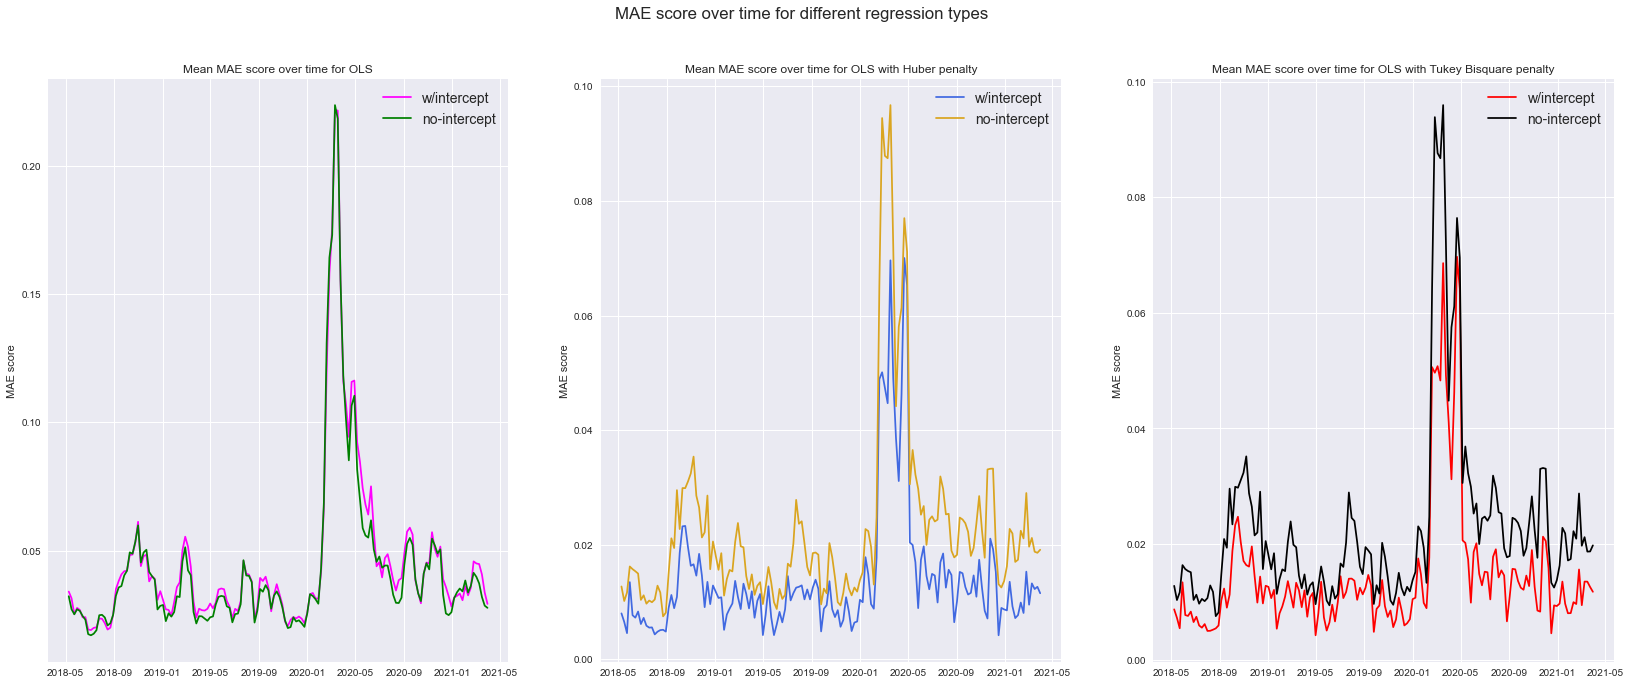

In [35]:
df1 = mae_with_inter_df.xs('OLS_w_int_MAE',level = 'regress_type',axis =1).mean(axis=1)
df2 = mae_with_inter_df.xs('Huber_w_int_MAE',level = 'regress_type',axis =1).mean(axis=1)
df3 = mae_with_inter_df.xs('Tukey_w_int_MAE',level = 'regress_type',axis =1).mean(axis=1)
df4 = mae_without_inter_df.xs('OLS_without_int_MAE',level = 'regress_type',axis =1).mean(axis=1)
df5 = mae_without_inter_df.xs('Huber_without_int_MAE',level = 'regress_type',axis =1).mean(axis=1)
df6 = mae_without_inter_df.xs('Tukey_without_int_MAE',level = 'regress_type',axis =1).mean(axis=1)

fig, axes = plt.subplots(1,3,figsize =(25,10))
plt.style.use('seaborn-bright')
plt.suptitle("MAE score over time for different regression types ")

axes[0].plot(df1,  c = 'magenta', label = 'w/intercept')
axes[0].plot(df4,  c = 'green', label = 'no-intercept')
axes[0].set_ylabel('MAE score')
axes[0].set_title("Mean MAE score over time for OLS")
axes[0].legend(fontsize= 14)

axes[1].plot(df2,  c = 'royalblue', label = 'w/intercept')
axes[1].plot(df5,  c = 'goldenrod', label = 'no-intercept')
axes[1].set_ylabel('MAE score')
axes[1].set_title("Mean MAE score over time for OLS with Huber penalty")
axes[1].legend(fontsize= 14)

axes[2].plot(df3,  c = 'red', label = 'w/intercept')
axes[2].plot(df6,  c = 'k', label = 'no-intercept')
axes[2].set_ylabel('MAE score')
axes[2].set_title("Mean MAE score over time for OLS with Tukey Bisquare penalty")
axes[2].legend(fontsize= 14)

plt.show()

It looks like intercept is doing better than without intercept, let's look at the relative difference among the two.

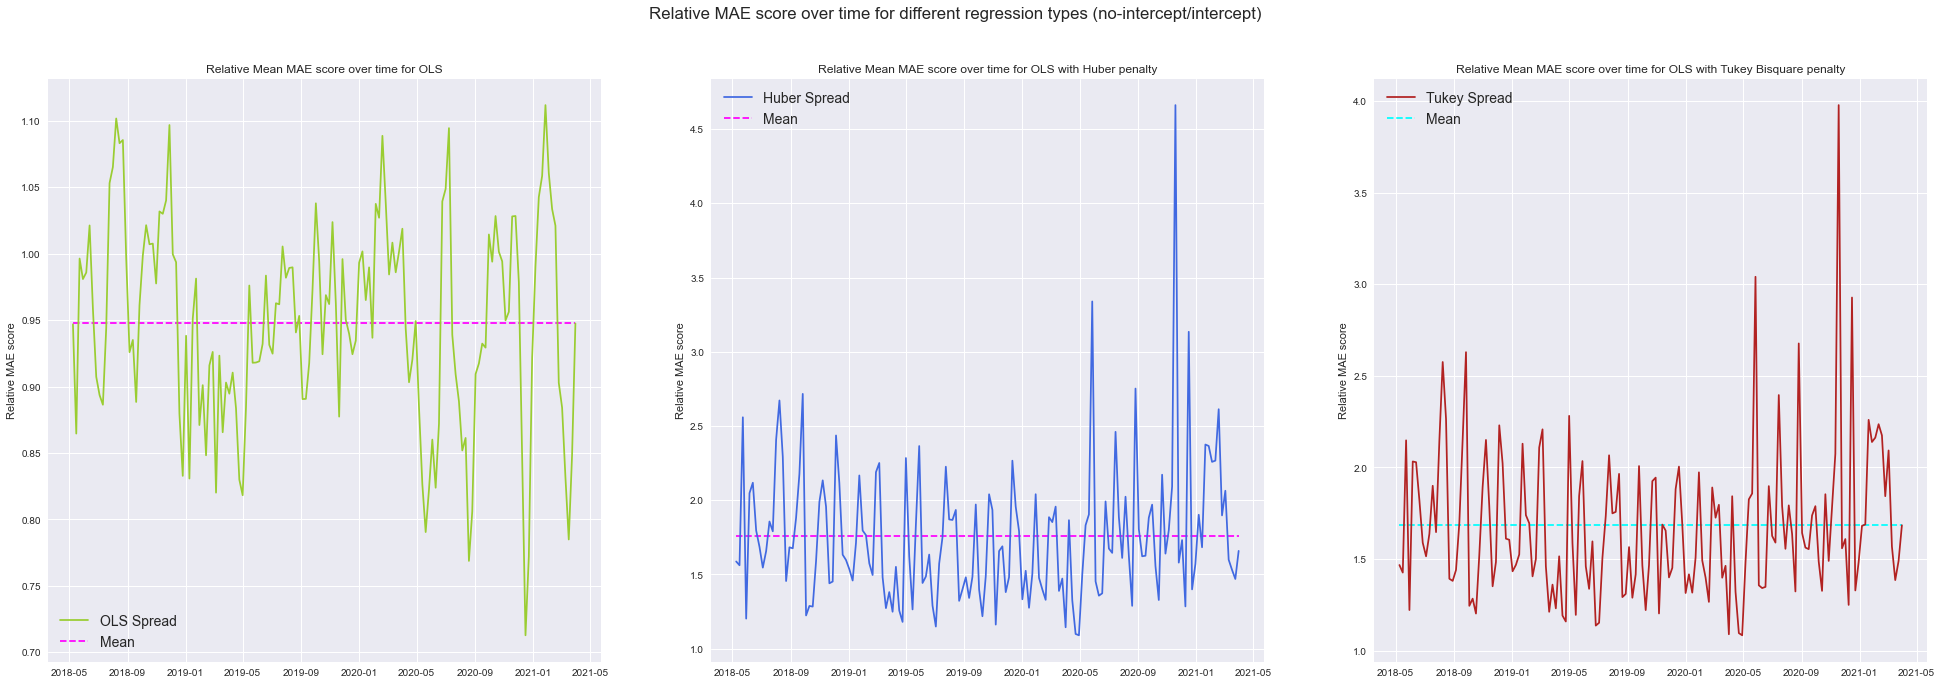

In [36]:
fig, axes = plt.subplots(1,3,figsize =(30,10))
plt.style.use('seaborn-bright')
plt.suptitle("Relative MAE score over time for different regression types (no-intercept/intercept)")

axes[0].plot(df4/df1,  c = 'yellowgreen', label = 'OLS Spread')
axes[0].hlines(y=(df4/df1).mean(),xmin=df1.index[0], xmax = df1.index[-1], color='magenta', linestyle='--', label='Mean')
axes[0].set_ylabel('Relative MAE score')
axes[0].set_title("Relative Mean MAE score over time for OLS")
axes[0].legend(fontsize= 14)

axes[1].plot(df5/df2,  c = 'royalblue', label = 'Huber Spread')
axes[1].hlines(y=(df5/df2).mean(),xmin=df1.index[0], xmax = df1.index[-1], color='magenta', linestyle='--', label='Mean')
axes[1].set_ylabel('Relative MAE score')
axes[1].set_title("Relative Mean MAE score over time for OLS with Huber penalty")
axes[1].legend(fontsize= 14)

axes[2].plot(df6/df3,  c = 'firebrick', label = 'Tukey Spread')
axes[2].hlines(y=(df6/df3).mean(),xmin=df1.index[0], xmax = df1.index[-1], color='cyan', linestyle='--', label='Mean')
axes[2].set_ylabel('Relative MAE score')
axes[2].set_title("Relative Mean MAE score over time for OLS with Tukey Bisquare penalty")
axes[2].legend(fontsize= 14)

plt.show()

In [37]:
print((df5/df2).mean(),(df6/df3).mean())

1.7575134533819472 1.6839552826504942


Interestingly, for the OLS. The average MAE is lower for no intercept than with intercept. For the Huber and Tukey, without intercept average MAE is 75%/68% higher respectively. Our OLS estimate is so poor that with or without intercept doesn't seem to affect the score by much while for the robust regressions techniques, there is a big difference between having the intercept or not. 

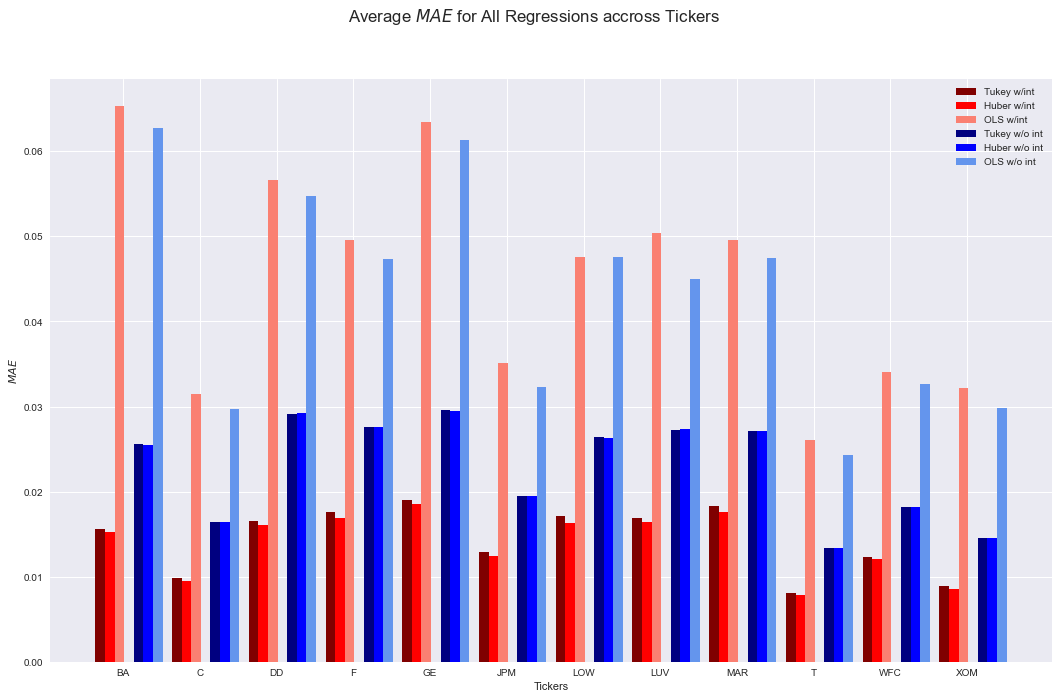

In [38]:
plt.style.use('seaborn-bright')
fig, axes = plt.subplots(1,1,figsize =(16,10))
fig.suptitle('Average $MAE$ for All Regressions accross Tickers')
df1 = mae_with_inter_df.xs('OLS_w_int_MAE',level = 'regress_type',axis =1).mean(axis =0 )
df2 = mae_with_inter_df.xs('Huber_w_int_MAE',level = 'regress_type',axis =1).mean(axis=0)
df3 = mae_with_inter_df.xs('Tukey_w_int_MAE',level = 'regress_type',axis =1).mean(axis=0)
df4 = mae_without_inter_df.xs('OLS_without_int_MAE',level = 'regress_type',axis =1).mean(axis=0)
df5 = mae_without_inter_df.xs('Huber_without_int_MAE',level = 'regress_type',axis =1).mean(axis=0)
df6 = mae_without_inter_df.xs('Tukey_without_int_MAE',level = 'regress_type',axis =1).mean(axis=0)

tickers = df1.index
ind = np.arange(len(tickers)) 
width = 1/8

bar1 = plt.bar(ind, df3,width,label = 'Tukey w/int',color = 'maroon')
bar2 = plt.bar(ind+width, df2, width,label = 'Huber w/int',color='red')
bar3  = plt.bar(ind+width*2, df1, width,label = 'OLS w/int',color='salmon')

bar4 = plt.bar(ind+width*4, df6, width,label = 'Tukey w/o int',color='navy')
bar5 = plt.bar(ind+width*5, df5, width,label = 'Huber w/o int',color = 'blue')
bar6 = plt.bar(ind+width*6, df4, width,label = 'OLS w/o int',color = 'cornflowerblue')

plt.xlabel("Tickers")
plt.ylabel('$MAE$')

plt.xticks(ind+.3,tickers)
plt.legend()
axes.legend()
plt.show()


Again here we can observe that for robusts regressions, the intercept definitely helps and that OLS with or without intercept marginally underperforms vs the robusts regressions.

# 4. Single Date Prediction

So far, our model score is based on the prediction of 1W to 4W looking forward but what if we wanted to test a single lag at a time? 

In [39]:
def OLS_lag(ticker, test_date, lag= 1, huber = False, tukey = False, intercept = True, to_plot = False, rmse = False):
    X = pd.concat([tickers_data[ticker],idx_ret],axis = 1)
    X_train = X.loc[test_date-timedelta(weeks = 16):test_date]
    X_test = X.loc[test_date+timedelta(weeks = 1):test_date+timedelta(weeks = 4)]

    y_train = cds_df[ticker].loc[test_date-timedelta(weeks = 16):test_date]
    y_test = cds_df[ticker].loc[test_date+timedelta(weeks = 1):test_date+timedelta(weeks = 4)] 
    if intercept:
        inter_str = " with intercept"
    else:
        inter_str = " without intercept"
        
    if not huber and not tukey:
        regression_type = "regular OLS"
        if intercept:
            model = lm.LinearRegression()
        else:
            model = lm.LinearRegression(fit_intercept = False)
        res = model.fit(X_train, y_train)
        y_pred = res.predict(X_test)
    else:
        if huber:
            regression_type = "robust Huber penalty function"
            if intercept:
                model = sm.RLM(y_test,sm.add_constant(X_test),M=sm.robust.norms.HuberT())
            else:
                model = sm.RLM(y_test,X_test,M=sm.robust.norms.HuberT())
        else:
            regression_type = "robust Tukey Bisquare penalty function"
            if intercept:
                model = sm.RLM(y_test,sm.add_constant(X_test),M=sm.robust.norms.TukeyBiweight())
            else:
                model = sm.RLM(y_test,X_test,M=sm.robust.norms.TukeyBiweight())
            
        res = model.fit()
        if intercept:
            y_pred = res.predict(sm.add_constant(X_test))
        else:
            y_pred = res.predict(X_test)
        resid = ((y_pred - y_test)**2).sum()
        total = ((y_test - y_test.mean())**2).sum()
    
    if to_plot:
        plt.style.use('ggplot')
        fig, ax = plt.subplots(figsize = (16,10))
        ax.plot(y_test.index, y_test, label = 'True value')
        ax.plot(y_test.index, y_pred, label = 'Fit')
        ax.set_ylabel("Weekly Returns for {}".format(ticker))
        ax.set_xlabel("Date")
        ax.set_title("Prediction vs Target using "+regression_type + inter_str)
        ax.legend(fontsize = 14)
        plt.show()
    
    target = y_pred[lag-1]
    target_test = y_test[lag-1]
    
    if rmse:
        return (target - target_test)**2
    else:
        return abs(target-target_test)
 

In [40]:
def gen_score_dic_lag(lag_ = 1, intercept_ = True, rmse_ = False):
    dic = {}
    if intercept_:
        str_int = "_w_int"
    else:
        str_int = "_without_int"
    if rmse_:
        str_score = "_RMSE"
    else:
        str_score = "_MAE"
    
    for ticker in tqdm(cds_df.columns[:-2]):
        
        df1 = cds_df['date'].iloc[17:-4].apply(lambda x : OLS_lag(ticker, x, lag = lag_,intercept = intercept_, rmse = rmse_))
        df1.name = 'OLS' + str_int + str_score
        df1.index = cds_df['date'].iloc[17:-4]
        df2 = cds_df['date'].iloc[17:-4].apply(lambda x: OLS_lag(ticker,x, lag = lag_,tukey = True, intercept = intercept_, rmse = rmse_))
        df2.name = 'Tukey'  + str_int + str_score
        df2.index = cds_df['date'].iloc[17:-4]
        df3 = cds_df['date'].iloc[17:-4].apply(lambda x: OLS_lag(ticker,x, lag = lag_,huber = True, intercept = intercept_, rmse = rmse_))
        df3.name = 'Huber'  + str_int + str_score
        df3.index = cds_df['date'].iloc[17:-4]
        dic[ticker] = pd.concat([df1,df2,df3],axis = 1)
    
    return dic

In [41]:
mae_lag1_inter_dict = gen_score_dic_lag(1)
mae_lag1_without_inter_dict = gen_score_dic_lag(1, intercept_ = False)
mae_lag2_inter_dict = gen_score_dic_lag(2)
mae_lag2_without_inter_dict = gen_score_dic_lag(2, intercept_ = False)
mae_lag3_inter_dict = gen_score_dic_lag(3)
mae_lag3_without_inter_dict = gen_score_dic_lag(3, intercept_ = False)
mae_lag4_inter_dict = gen_score_dic_lag(4)
mae_lag4_without_inter_dict = gen_score_dic_lag(4, intercept_ = False)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:34<00:00,  2.85s/it]


In [42]:
mae_lag1_with_inter_df = concat_dic_to_df(mae_lag1_inter_dict)
mae_lag1_without_inter_df = concat_dic_to_df(mae_lag1_without_inter_dict)
mae_lag2_with_inter_df = concat_dic_to_df(mae_lag2_inter_dict)
mae_lag2_without_inter_df = concat_dic_to_df(mae_lag2_without_inter_dict)
mae_lag3_with_inter_df = concat_dic_to_df(mae_lag3_inter_dict)
mae_lag3_without_inter_df = concat_dic_to_df(mae_lag3_without_inter_dict)
mae_lag4_with_inter_df = concat_dic_to_df(mae_lag4_inter_dict)
mae_lag4_without_inter_df = concat_dic_to_df(mae_lag4_without_inter_dict)
mae_lag1_with_inter_df.head()

ticker                  BA                                             C  \
regress_type OLS_w_int_MAE Tukey_w_int_MAE Huber_w_int_MAE OLS_w_int_MAE   
date                                                                       
2018-05-09        0.003450        0.006396        0.006662      0.051917   
2018-05-16        0.010016        0.001057        0.001077      0.078905   
2018-05-23        0.027600        0.002803        0.002778      0.007079   
2018-05-30        0.039187        0.011634        0.011382      0.074522   
2018-06-06        0.031574        0.005705        0.006025      0.019317   

ticker                                                  DD                  \
regress_type Tukey_w_int_MAE Huber_w_int_MAE OLS_w_int_MAE Tukey_w_int_MAE   
date                                                                         
2018-05-09      1.387779e-17    1.381548e-07      0.019934        0.002295   
2018-05-16      3.854292e-02    4.858076e-02      0.031602        0.005650   
2018-05-23      1.986088e-02    2.577856e-02      0.004239        0.002504   
2018-05-30      1.321884e-02    1.352088e-02      0.053446        0.014381   
2018-06-06      9.113344e-03    9.573317e-03      0.028716        0.005566   

ticker                                   F  ...             MAR             T  \
regress_type Huber_w_int_MAE OLS_w_int_MAE  ... Huber_w_int_MAE OLS_w_int_MAE   
date                                        ...                                 
2018-05-09          0.002388      0.037857  ...        0.007336      0.013413   
2018-05-16          0.007414      0.017457  ...        0.066572      0.002533   
2018-05-23          0.002407      0.028594  ...        0.063842      0.004491   
2018-05-30          0.014272      0.008323  ...        0.070557      0.015069   
2018-06-06          0.006347      0.000159  ...        0.011843      0.004262   

ticker                                                 WFC                  \
regress_type Tukey_w_int_MAE Huber_w_int_MAE OLS_w_int_MAE Tukey_w_int_MAE   
date                                                                         
2018-05-09          0.000014    5.324226e-11      0.067692        0.003093   
2018-05-16          0.000060    7.592739e-08      0.042784        0.012222   
2018-05-23          0.000295    4.105129e-04      0.012496        0.026025   
2018-05-30          0.001287    1.276918e-03      0.056981        0.030540   
2018-06-06          0.002267    2.375920e-03      0.004859        0.000545   

ticker                                 XOM                                  
regress_type Huber_w_int_MAE OLS_w_int_MAE Tukey_w_int_MAE Huber_w_int_MAE  
date                                                                        
2018-05-09          0.003598      0.011081        0.000681    9.178737e-09  
2018-05-16          0.013738      0.011382        0.005575    7.451414e-03  
2018-05-23          0.034256      0.001077        0.003026    3.010228e-03  
2018-05-30          0.030941      0.005021        0.006855    6.817107e-03  
2018-06-06          0.000609      0.005176        0.000471    4.568578e-04  

[5 rows x 36 columns]

In [43]:
mae_int_list = [mae_lag1_with_inter_df, mae_lag2_with_inter_df, mae_lag3_with_inter_df, mae_lag4_with_inter_df]
mae_no_int_list = [mae_lag1_without_inter_df, mae_lag2_without_inter_df, mae_lag3_without_inter_df, mae_lag4_without_inter_df]

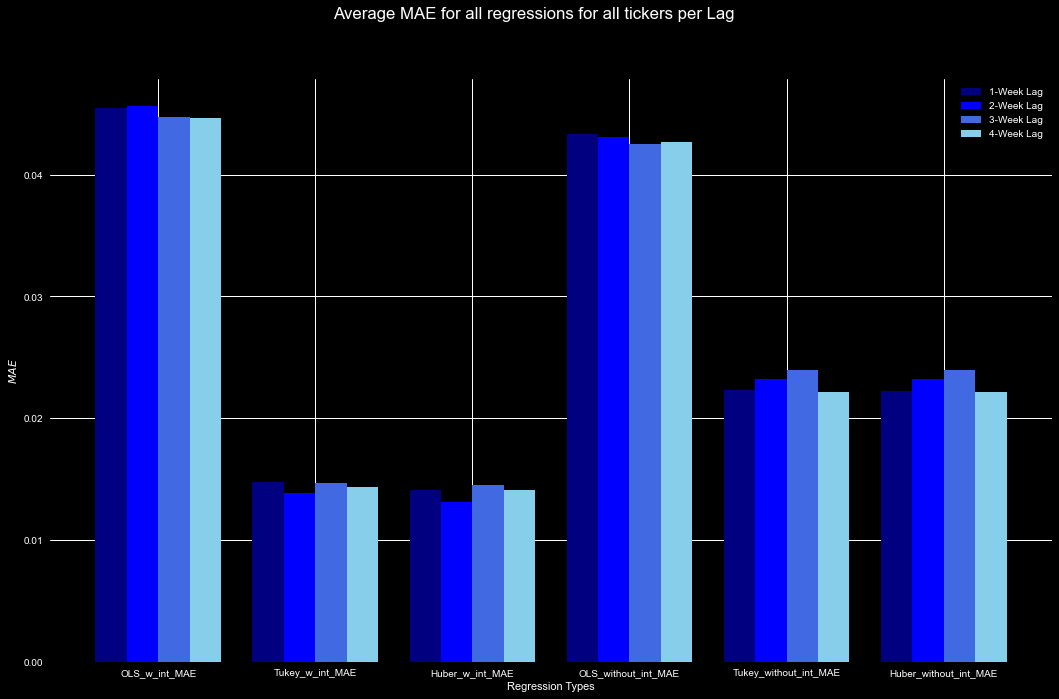

In [44]:
plt.style.use('dark_background')
fig, axes = plt.subplots(1,1,figsize =(16,10))
fig.suptitle('Average MAE for all regressions for all tickers per Lag')

dfs_int = []
dfs_no_int = []
dfs_merge = []
for i in range(4):
    temp1 = pd.DataFrame(data = None, index = ["OLS_w_int_MAE", "Tukey_w_int_MAE", "Huber_w_int_MAE"], columns = ['mae'])
    temp2 = pd.DataFrame(data = None, index = ["OLS_without_int_MAE", "Tukey_without_int_MAE", "Huber_without_int_MAE"], columns = ['mae'])
    for idx in temp1.index:
        temp1.loc[idx] = mae_int_list[i].xs(idx,level = 'regress_type',axis =1).mean().mean()
    for idx in temp2.index:
        temp2.loc[idx] = mae_no_int_list[i].xs(idx,level = 'regress_type',axis =1).mean().mean()
    dfs_int.append(temp1.T) 
    dfs_no_int.append(temp2.T)
    dfs_merge.append(pd.concat([temp1.T, temp2.T],axis=1).T)

ind = np.arange(6) 
width = 1/5
series_idx = ["OLS_w_int_MAE", "Tukey_w_int_MAE", "Huber_w_int_MAE", "OLS_without_int_MAE", "Tukey_without_int_MAE", "Huber_without_int_MAE"]

bar1 = plt.bar(ind,pd.Series(dfs_merge[0].values.reshape(6,), index = series_idx),width,label = '1-Week Lag',color = 'navy')
bar2 = plt.bar(ind+width,pd.Series(dfs_merge[1].values.reshape(6,), index = series_idx),width,label = '2-Week Lag',color = 'blue')
bar3 = plt.bar(ind+2*width,pd.Series(dfs_merge[2].values.reshape(6,), index = series_idx),width,label = '3-Week Lag',color = 'royalblue')
bar4 = plt.bar(ind+3*width,pd.Series(dfs_merge[3].values.reshape(6,), index = series_idx),width,label = '4-Week Lag',color = 'skyblue')

plt.xlabel("Regression Types")
plt.ylabel('$MAE$')

plt.legend()
plt.xticks(ind+.3,series_idx)
axes.legend()
plt.show()

Here we can observe that the lag period doesn't really affect the MAE score but the type of regression certainly does. The two lowest one are the robust regression with intercept and the 2 highest ones are the OLS ones. This is in agreement with our previous analysis that if we had to have 3 classification from worst to best, we have:

* OLS (with and without intercept)
* Robust Regressions without intercept
* Robust Regressions with intercept

Let's look at RMSE see if tells another story.

In [45]:
rmse_lag1_inter_dict = gen_score_dic_lag(1, rmse_ = True)
rmse_lag1_without_inter_dict = gen_score_dic_lag(1, intercept_ = False, rmse_ = True)
rmse_lag2_inter_dict = gen_score_dic_lag(2, rmse_ = True)
rmse_lag2_without_inter_dict = gen_score_dic_lag(2, intercept_ = False, rmse_ = True)
rmse_lag3_inter_dict = gen_score_dic_lag(3, rmse_ = True)
rmse_lag3_without_inter_dict = gen_score_dic_lag(3, intercept_ = False, rmse_ = True)
rmse_lag4_inter_dict = gen_score_dic_lag(4, rmse_ = True)
rmse_lag4_without_inter_dict = gen_score_dic_lag(4, intercept_ = False, rmse_ = True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:41<00:00,  3.47s/it]


In [46]:
rmse_lag1_with_inter_df = concat_dic_to_df(rmse_lag1_inter_dict)
rmse_lag1_without_inter_df = concat_dic_to_df(rmse_lag1_without_inter_dict)
rmse_lag2_with_inter_df = concat_dic_to_df(rmse_lag2_inter_dict)
rmse_lag2_without_inter_df = concat_dic_to_df(rmse_lag2_without_inter_dict)
rmse_lag3_with_inter_df = concat_dic_to_df(rmse_lag3_inter_dict)
rmse_lag3_without_inter_df = concat_dic_to_df(rmse_lag3_without_inter_dict)
rmse_lag4_with_inter_df = concat_dic_to_df(rmse_lag4_inter_dict)
rmse_lag4_without_inter_df = concat_dic_to_df(rmse_lag4_without_inter_dict)
rmse_lag1_with_inter_df.head()

ticker                   BA                                                C  \
regress_type OLS_w_int_RMSE Tukey_w_int_RMSE Huber_w_int_RMSE OLS_w_int_RMSE   
date                                                                           
2018-05-09         0.000012         0.000041         0.000044       0.002695   
2018-05-16         0.000100         0.000001         0.000001       0.006226   
2018-05-23         0.000762         0.000008         0.000008       0.000050   
2018-05-30         0.001536         0.000135         0.000130       0.005553   
2018-06-06         0.000997         0.000033         0.000036       0.000373   

ticker                                                     DD  \
regress_type Tukey_w_int_RMSE Huber_w_int_RMSE OLS_w_int_RMSE   
date                                                            
2018-05-09       1.925930e-34     1.908675e-14       0.000397   
2018-05-16       1.485557e-03     2.360090e-03       0.000999   
2018-05-23       3.944547e-04     6.645342e-04       0.000018   
2018-05-30       1.747378e-04     1.828142e-04       0.002856   
2018-06-06       8.305305e-05     9.164841e-05       0.000825   

ticker                                                      F  ...  \
regress_type Tukey_w_int_RMSE Huber_w_int_RMSE OLS_w_int_RMSE  ...   
date                                                           ...   
2018-05-09           0.000005         0.000006   1.433121e-03  ...   
2018-05-16           0.000032         0.000055   3.047640e-04  ...   
2018-05-23           0.000006         0.000006   8.176222e-04  ...   
2018-05-30           0.000207         0.000204   6.926992e-05  ...   
2018-06-06           0.000031         0.000040   2.523567e-08  ...   

ticker                    MAR              T                   \
regress_type Huber_w_int_RMSE OLS_w_int_RMSE Tukey_w_int_RMSE   
date                                                            
2018-05-09           0.000054       0.000180     1.981207e-10   
2018-05-16           0.004432       0.000006     3.556489e-09   
2018-05-23           0.004076       0.000020     8.673879e-08   
2018-05-30           0.004978       0.000227     1.656701e-06   
2018-06-06           0.000140       0.000018     5.139256e-06   

ticker                                   WFC                   \
regress_type Huber_w_int_RMSE OLS_w_int_RMSE Tukey_w_int_RMSE   
date                                                            
2018-05-09       2.834739e-21       0.004582     9.564250e-06   
2018-05-16       5.764969e-15       0.001830     1.493690e-04   
2018-05-23       1.685208e-07       0.000156     6.772915e-04   
2018-05-30       1.630520e-06       0.003247     9.326800e-04   
2018-06-06       5.644997e-06       0.000024     2.969031e-07   

ticker                                   XOM                                    
regress_type Huber_w_int_RMSE OLS_w_int_RMSE Tukey_w_int_RMSE Huber_w_int_RMSE  
date                                                                            
2018-05-09       1.294713e-05       0.000123     4.632677e-07     8.424922e-17  
2018-05-16       1.887246e-04       0.000130     3.108246e-05     5.552357e-05  
2018-05-23       1.173458e-03       0.000001     9.156907e-06     9.061475e-06  
2018-05-30       9.573189e-04       0.000025     4.699207e-05     4.647295e-05  
2018-06-06       3.704399e-07       0.000027     2.218509e-07     2.087190e-07  

[5 rows x 36 columns]

In [47]:
rmse_int_list = [rmse_lag1_with_inter_df, rmse_lag2_with_inter_df, rmse_lag3_with_inter_df, rmse_lag4_with_inter_df]
rmse_no_int_list = [rmse_lag1_without_inter_df, rmse_lag2_without_inter_df, rmse_lag3_without_inter_df, rmse_lag4_without_inter_df]

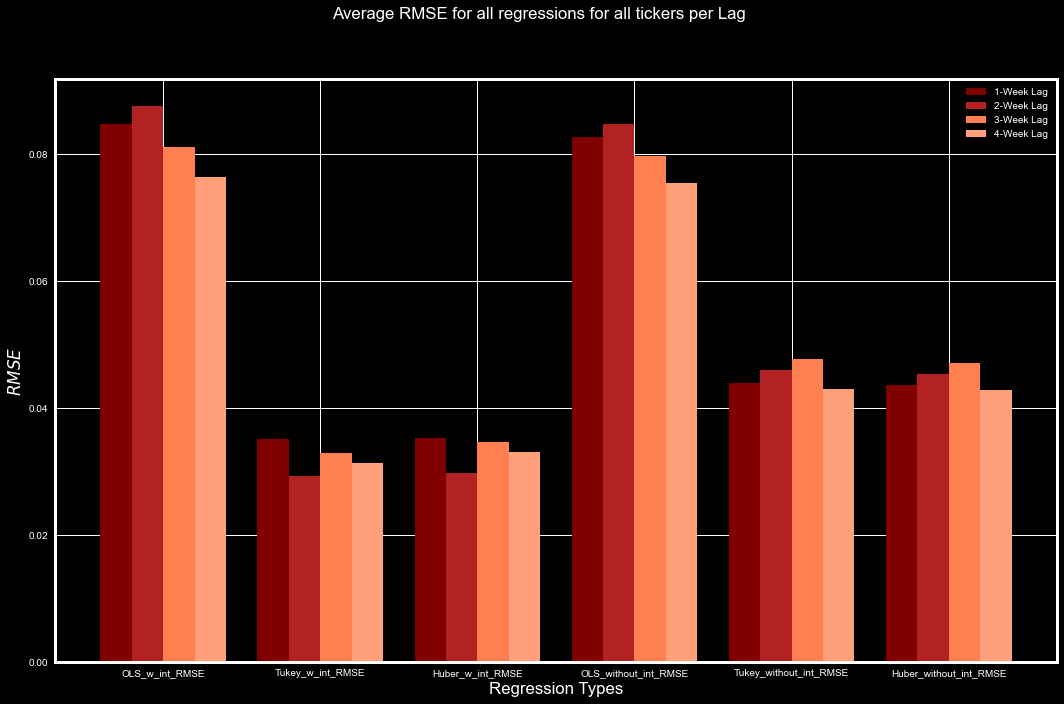

In [48]:
plt.style.use('dark_background')
fig, axes = plt.subplots(1,1,figsize =(16,10))
fig.suptitle('Average RMSE for all regressions for all tickers per Lag')

dfs_int = []
dfs_no_int = []
dfs_merge = []
for i in range(4):
    temp1 = pd.DataFrame(data = None, index = ["OLS_w_int_RMSE", "Tukey_w_int_RMSE", "Huber_w_int_RMSE"], columns = ['rmse'])
    temp2 = pd.DataFrame(data = None, index = ["OLS_without_int_RMSE", "Tukey_without_int_RMSE", "Huber_without_int_RMSE"], columns = ['rmse'])
    for idx in temp1.index:
        temp1.loc[idx] = np.sqrt(rmse_int_list[i].xs(idx,level = 'regress_type',axis =1).mean().mean())
    for idx in temp2.index:
        temp2.loc[idx] = np.sqrt(rmse_no_int_list[i].xs(idx,level = 'regress_type',axis =1).mean().mean())
    dfs_int.append(temp1.T) 
    dfs_no_int.append(temp2.T)
    dfs_merge.append(pd.concat([temp1.T, temp2.T],axis=1).T)

ind = np.arange(6) 
width = 1/5
series_idx = ["OLS_w_int_RMSE", "Tukey_w_int_RMSE", "Huber_w_int_RMSE", "OLS_without_int_RMSE", "Tukey_without_int_RMSE", "Huber_without_int_RMSE"]

bar1 = plt.bar(ind,pd.Series(dfs_merge[0].values.reshape(6,), index = series_idx),width,label = '1-Week Lag',color = 'maroon')
bar2 = plt.bar(ind+width,pd.Series(dfs_merge[1].values.reshape(6,), index = series_idx),width,label = '2-Week Lag',color = 'firebrick')
bar3 = plt.bar(ind+2*width,pd.Series(dfs_merge[2].values.reshape(6,), index = series_idx),width,label = '3-Week Lag',color = 'coral')
bar4 = plt.bar(ind+3*width,pd.Series(dfs_merge[3].values.reshape(6,), index = series_idx),width,label = '4-Week Lag',color = 'lightsalmon')

plt.xlabel("Regression Types")
plt.ylabel('$RMSE$')

plt.legend()
plt.xticks(ind+.3,series_idx)
axes.legend()
plt.show()

Similar information than from MAE, robust regression perform better and the lag time doesn't seem to affect the scoring as much as the choice of model. For the robust regressions, having an intercept improves the score.

# 5. Conclusion

We saw that two of our tickers have extremely hectic behaviors mainly (T,XOM) at some point and the classic OLS regression has horrible predictions when things falls off the wheels. The use of more robust regression methods like Huber and Tukey allows us to manage extremes much better. This is very useful in financial context where our data rarely has normal distribution but usually has fat tailed distributions. 

When comparing the $R^2$ between Huber and Tukey, it seems that with intercept the Huber penalty gave better results accross the board but without an intercept the two penalty were not trivially distinguishable. Regardless, beside some statistical scoring around the classic OLS, having an intercept seemed to be better across the board in all of our analysis. The distinction between using an intercept versus not using an intercept is more important than the choice of penalty. We saw this when comparing the relative MAE with and without intercept and saw that without intercept is on average ~65% higher than with intercept. Being more accurate, we also noticed more improvement in accuracy in prediction when using an intercept for the robust regressions vs non-robusts. 

When looking at $MAE$ and $RMSE$ for various lags, it doesn't look like the period of lag has a significant impact on the scoring compared to the choice of model. Given a longer time period of prediction, we might observe a more significant impact but mainly, in the last section of the notebook we see the same story that using Tukey and Huber has a better scoring than OLS and using an intercept also improves the model. 